# Customer segmentation project - Barath_Raj_ASOKAN

Your are a datascientist working as a consultant for [Olist](https://olist.com/), a sales solution for online marketplaces.


Olist wants you to develop a customer segmentation that its marketing teams can use on a routine basis for their communicaion campaigns. 


You have an initial meeting with Olist's Marketing Director, Sophia, to better understand the need of the project. Here somme notes you took : 
- Olist marketing teams need an actionable description of the segmentation that allows them to thoroughly grasp its underlying logic (Notebook format).
- The [database](https://www.kaggle.com/olistbr/brazilian-ecommerce) contains information such as order history, products purchased, customer satisfaction comments, and location.
- The quality of the data is somewhat poor. The idea is to create the best possible features for making optimum use of them.
- Customer segmentation means understand the different types of users. Unsupervised algorithm is probably the best to use. 
- The segmentation needs to be robust: adding a few new customers to the database and creating a new segmentation using the same model should not result in totally different conclusions.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# 1. Join the different datasets into one dataset

In [2]:
# Please feel free to add your own means of importing data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
customers_df = pd.read_csv('/content/drive/MyDrive/olist_customers_dataset.csv')
items_df = pd.read_csv('/content/drive/MyDrive/olist_order_items_dataset.csv')
payments_df = pd.read_csv('/content/drive/MyDrive/olist_order_payments_dataset.csv')
orders_df = pd.read_csv('/content/drive/MyDrive/olist_orders_dataset.csv')
products_df = pd.read_csv('/content/drive/MyDrive/olist_products_dataset.csv')
sellers_df = pd.read_csv('/content/drive/MyDrive/olist_sellers_dataset.csv')
categories_df = pd.read_csv('/content/drive/MyDrive/product_category_name_translation.csv')

In [ ]:
# To know the shape of all dataframes
dataframes = {'customers': customers_df,
              'items': items_df, 
              'payments': payments_df, 
              'orders': orders_df, 
              'products': products_df, 
              'sellers': sellers_df, 
              'categories': categories_df}
for i, j in dataframes.items():
    print(f'{i:12s} dataframe: {str(len(j)):7s} rows')

customers    dataframe: 99441   rows
items        dataframe: 112650  rows
payments     dataframe: 103886  rows
orders       dataframe: 99441   rows
products     dataframe: 32951   rows
sellers      dataframe: 3095    rows
categories   dataframe: 71      rows


In [4]:
#Merging all the data into one DataFrame
df = pd.merge(orders_df, customers_df, on='customer_id')
df = df.merge(items_df, on='order_id')
df = df.merge(payments_df, on='order_id')
df = df.merge(products_df, on='product_id')
df = df.merge(sellers_df, on='seller_id')

In [ ]:
df.head()

order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
2  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
3  128e10d95713541c87cd1a2e48201934  a20e8105f23924cd00833fd87daa0831   
4  0e7e841ddf8f8f2de2bad69267ecfbcf  26c7ac168e1433912a51b924fbd34d34   

  order_status order_purchase_timestamp    order_approved_at  \
0    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
1    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
2    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
3    delivered      2017-08-15 18:29:31  2017-08-15 20:05:16   
4    delivered      2017-08-02 18:24:47  2017-08-02 18:43:15   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2017-10-04 19:55:00           2017-10-10 21:25:13   
2          2017-10-04 19:55:00           2017-10-10 21:25:13   
3          2017-08-17 15:28:33           2017-08-18 14:44:43   
4          2017-08-04 17:35:43           2017-08-07 18:30:01   

  order_estimated_delivery_date                customer_unique_id  \
0           2017-10-18 00:00:00  7c396fd4830fd04220f754e42b4e5bff   
1           2017-10-18 00:00:00  7c396fd4830fd04220f754e42b4e5bff   
2           2017-10-18 00:00:00  7c396fd4830fd04220f754e42b4e5bff   
3           2017-08-28 00:00:00  3a51803cc0d012c3b5dc8b7528cb05f7   
4           2017-08-15 00:00:00  ef0996a1a279c26e7ecbd737be23d235   

   customer_zip_code_prefix  ... product_name_lenght  \
0                      3149  ...                40.0   
1                      3149  ...                40.0   
2                      3149  ...                40.0   
3                      3366  ...                40.0   
4                      2290  ...                40.0   

  product_description_lenght  product_photos_qty product_weight_g  \
0                      268.0                 4.0            500.0   
1                      268.0                 4.0            500.0   
2                      268.0                 4.0            500.0   
3                      268.0                 4.0            500.0   
4                      268.0                 4.0            500.0   

  product_length_cm product_height_cm  product_width_cm  \
0              19.0               8.0              13.0   
1              19.0               8.0              13.0   
2              19.0               8.0              13.0   
3              19.0               8.0              13.0   
4              19.0               8.0              13.0   

   seller_zip_code_prefix  seller_city seller_state  
0                    9350         maua           SP  
1                    9350         maua           SP  
2                    9350         maua           SP  
3                    9350         maua           SP  
4                    9350         maua           SP  

[5 rows x 33 columns]

# 2. Understand, analyse and clean the dataset

In [ ]:
def missing_values_in_df(df):
    total = df.isnull().sum().sort_values(ascending = False)
    percent = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending = False)
    return pd.concat([total, percent], axis=1, keys=['total_missing_values', 'percent_missing_values'])

In [ ]:
df.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'customer_unique_id', 'customer_zip_code_prefix', 'customer_city',
       'customer_state', 'order_item_id', 'product_id', 'seller_id',
       'shipping_limit_date', 'price', 'freight_value', 'payment_sequential',
       'payment_type', 'payment_installments', 'payment_value',
       'product_category_name', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm',
       'seller_zip_code_prefix', 'seller_city', 'seller_state'],
      dtype='object')

In [ ]:
df.describe()

customer_zip_code_prefix  order_item_id          price  freight_value  \
count             117601.000000  117601.000000  117601.000000  117601.000000   
mean               35051.793097       1.195900     120.824783      20.045990   
std                29820.588877       0.697706     184.479323      15.861315   
min                 1003.000000       1.000000       0.850000       0.000000   
25%                11310.000000       1.000000      39.900000      13.080000   
50%                24315.000000       1.000000      74.900000      16.290000   
75%                58600.000000       1.000000     134.900000      21.190000   
max                99990.000000      21.000000    6735.000000     409.680000   

       payment_sequential  payment_installments  payment_value  \
count       117601.000000         117601.000000  117601.000000   
mean             1.093528              2.939482     172.686752   
std              0.726692              2.774223     267.592290   
min              1.000000              0.000000       0.000000   
25%              1.000000              1.000000      60.870000   
50%              1.000000              2.000000     108.210000   
75%              1.000000              4.000000     189.260000   
max             29.000000             24.000000   13664.080000   

       product_name_lenght  product_description_lenght  product_photos_qty  \
count        115903.000000               115903.000000       115903.000000   
mean             48.767590                  786.950855            2.207881   
std              10.035011                  653.036231            1.719531   
min               5.000000                    4.000000            1.000000   
25%              42.000000                  347.000000            1.000000   
50%              52.000000                  601.000000            1.000000   
75%              57.000000                  985.000000            3.000000   
max              76.000000                 3992.000000           20.000000   

       product_weight_g  product_length_cm  product_height_cm  \
count     117581.000000      117581.000000      117581.000000   
mean        2114.309497          30.257235          16.630306   
std         3788.798201          16.190920          13.458952   
min            0.000000           7.000000           2.000000   
25%          300.000000          18.000000           8.000000   
50%          700.000000          25.000000          13.000000   
75%         1800.000000          38.000000          20.000000   
max        40425.000000         105.000000         105.000000   

       product_width_cm  seller_zip_code_prefix  
count     117581.000000           117601.000000  
mean          23.068574            24441.423049  
std           11.748468            27572.632286  
min            6.000000             1001.000000  
25%           15.000000             6429.000000  
50%           20.000000            13660.000000  
75%           30.000000            28035.000000  
max          118.000000            99730.000000

In [ ]:
df.dtypes

order_id                          object
customer_id                       object
order_status                      object
order_purchase_timestamp          object
order_approved_at                 object
order_delivered_carrier_date      object
order_delivered_customer_date     object
order_estimated_delivery_date     object
customer_unique_id                object
customer_zip_code_prefix           int64
customer_city                     object
customer_state                    object
order_item_id                      int64
product_id                        object
seller_id                         object
shipping_limit_date               object
price                            float64
freight_value                    float64
payment_sequential                 int64
payment_type                      object
payment_installments               int64
payment_value                    float64
product_category_name             object
product_name_lenght              float64
product_descript

In [5]:
#Converting all the Dates to the Datetime64 data type
dates = ['order_purchase_timestamp','order_approved_at', 'order_delivered_carrier_date',
         'order_delivered_customer_date', 'order_estimated_delivery_date','shipping_limit_date']
for col in dates:
    df[col] = pd.to_datetime(df[col])
df.dtypes

order_id                                 object
customer_id                              object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
customer_unique_id                       object
customer_zip_code_prefix                  int64
customer_city                            object
customer_state                           object
order_item_id                             int64
product_id                               object
seller_id                                object
shipping_limit_date              datetime64[ns]
price                                   float64
freight_value                           float64
payment_sequential                        int64
payment_type                             object
payment_installments                    

In [ ]:
#Missing values in the whole dataset
missing_values_in_df(df)

total_missing_values  percent_missing_values
order_delivered_customer_date                  2567                2.182805
product_name_lenght                            1698                1.443865
product_category_name                          1698                1.443865
product_photos_qty                             1698                1.443865
product_description_lenght                     1698                1.443865
order_delivered_carrier_date                   1245                1.058664
product_length_cm                                20                0.017007
product_width_cm                                 20                0.017007
product_height_cm                                20                0.017007
product_weight_g                                 20                0.017007
order_approved_at                                15                0.012755
payment_installments                              0                0.000000
payment_value                                     0                0.000000
order_id                                          0                0.000000
payment_sequential                                0                0.000000
seller_zip_code_prefix                            0                0.000000
seller_city                                       0                0.000000
payment_type                                      0                0.000000
price                                             0                0.000000
freight_value                                     0                0.000000
customer_id                                       0                0.000000
shipping_limit_date                               0                0.000000
seller_id                                         0                0.000000
product_id                                        0                0.000000
order_item_id                                     0                0.000000
customer_state                                    0                0.000000
customer_city                                     0                0.000000
customer_zip_code_prefix                          0                0.000000
customer_unique_id                                0                0.000000
order_estimated_delivery_date                     0                0.000000
order_purchase_timestamp                          0                0.000000
order_status                                      0                0.000000
seller_state                                      0                0.000000

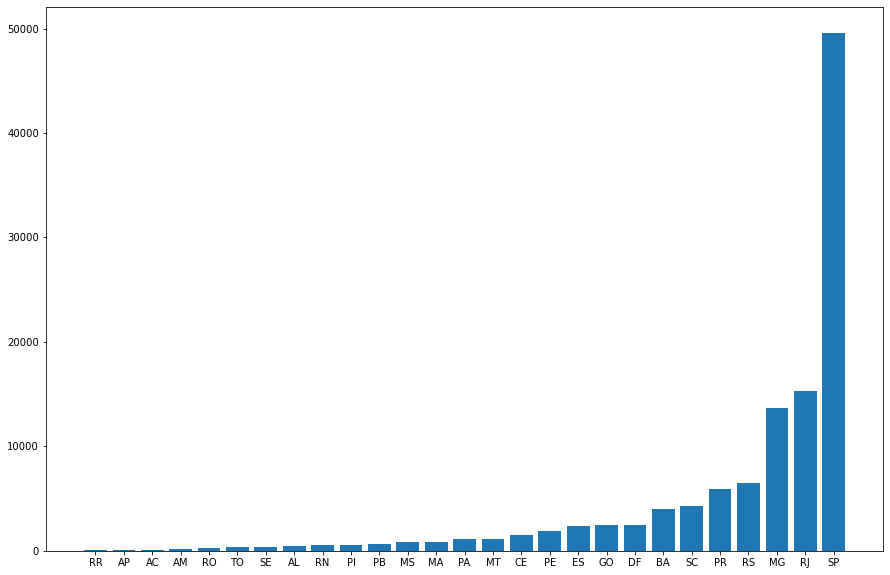

In [ ]:
# Customer by state to see which state has the maximum customers
customer_by_state = df[['customer_unique_id', 'customer_state']].groupby('customer_state').count().reset_index()
customer_by_state = customer_by_state.sort_values(by=['customer_unique_id'])

plt.figure(figsize=(15,10))
plt.bar(customer_by_state['customer_state'], customer_by_state['customer_unique_id'])
plt.show()b

#### From the above graph we can see that Sao Paulo (SP) has the most customers

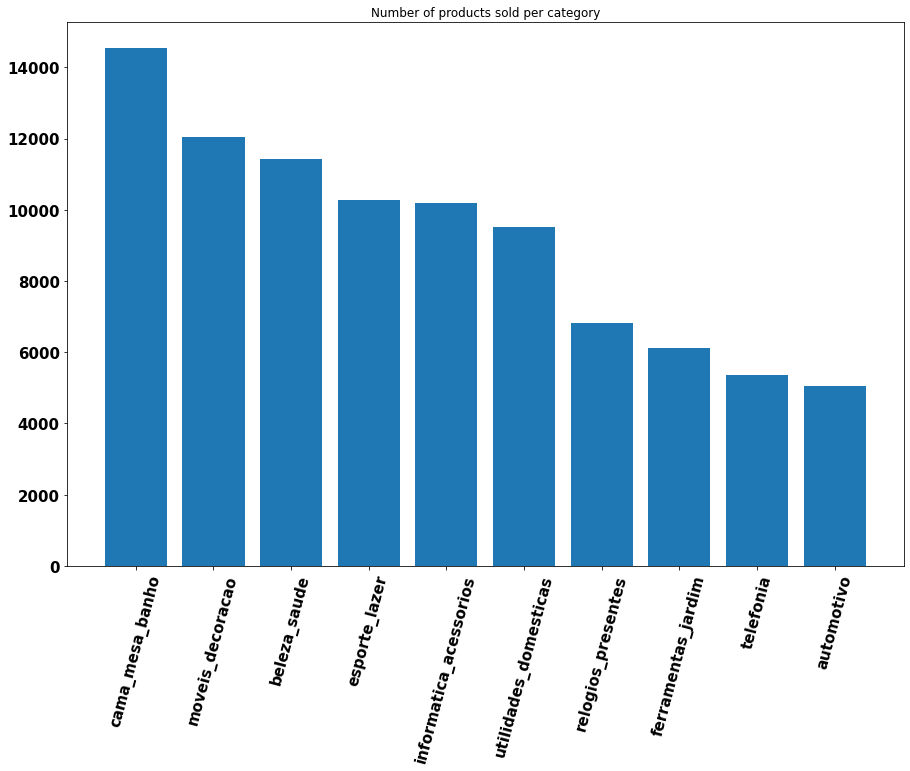

In [ ]:
#To see which category is ordered the maximum
top_categories = df[['product_category_name', 'order_item_id']]
top_categories = top_categories.groupby(['product_category_name']).sum().sort_values(by=['order_item_id'],
                                                                                ascending=False).reset_index()

plt.figure(figsize=(15,10))
plt.bar(top_categories['product_category_name'][:10], top_categories['order_item_id'][:10])
plt.title('Number of products sold per category')
plt.xticks(rotation=75, fontsize=15, weight='bold')
plt.yticks(fontsize=15, weight='bold')
plt.show()

#### So the cama_mesa_banho is the most ordered project category

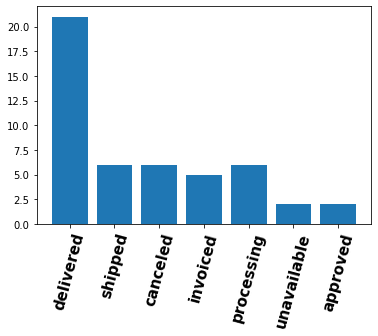

In [ ]:
#To check the Status of the orders
plt.bar(df['order_status'],df['order_item_id'])
plt.xticks(rotation=75, fontsize=15, weight='bold')
plt.show()

In [ ]:
df[dates].describe()

order_purchase_timestamp    order_approved_at  \
count                    117601               117586   
unique                    98111                90173   
top         2017-08-08 20:26:31  2017-08-08 20:43:31   
freq                         63                   63   
first       2016-09-04 21:15:19  2016-10-04 09:43:32   
last        2018-09-03 09:06:57  2018-09-03 17:40:06   

       order_delivered_carrier_date order_delivered_customer_date  \
count                        116356                        115034   
unique                        81016                         95663   
top             2017-08-10 11:58:14           2017-08-14 12:46:18   
freq                             63                            63   
first           2016-10-08 10:34:01           2016-10-11 13:46:32   
last            2018-09-11 19:48:28           2018-10-17 13:22:46   

       order_estimated_delivery_date  shipping_limit_date  
count                         117601               117601  
unique                           449                93317  
top              2017-12-20 00:00:00  2017-08-14 20:43:31  
freq                             649                   63  
first            2016-10-20 00:00:00  2016-09-19 00:15:34  
last             2018-10-25 00:00:00  2020-04-09 22:35:08

### Since the Delivered orders are of our concern we will consider those for our Recency calculation:
### Max : 2018-08-10
### Min : 2016-10-08

In [6]:
#The Timestamp variable does not offer any valuable insight so we shall make it into Year, Month and Day
df['order_purchase_year'] = pd.to_datetime(df['order_purchase_timestamp']).dt.year
df['order_purchase_month'] = pd.to_datetime(df['order_purchase_timestamp']).dt.month
df['order_purchase_day'] = pd.to_datetime(df['order_purchase_timestamp']).dt.day

In [ ]:
df.groupby(['order_purchase_year']).count() #So we can see that 2018 had the highest number of purchases

order_id  customer_id  order_status  \
order_purchase_year                                        
2016                      385          385           385   
2017                    53539        53539         53539   
2018                    63677        63677         63677   

                     order_purchase_timestamp  order_approved_at  \
order_purchase_year                                                
2016                                      385                385   
2017                                    53539              53524   
2018                                    63677              63677   

                     order_delivered_carrier_date  \
order_purchase_year                                 
2016                                          348   
2017                                        52756   
2018                                        63252   

                     order_delivered_customer_date  \
order_purchase_year                                  
2016                                           337   
2017                                         52146   
2018                                         62551   

                     order_estimated_delivery_date  customer_unique_id  \
order_purchase_year                                                      
2016                                           385                 385   
2017                                         53539               53539   
2018                                         63677               63677   

                     customer_zip_code_prefix  ...  product_photos_qty  \
order_purchase_year                            ...                       
2016                                      385  ...                 383   
2017                                    53539  ...               52562   
2018                                    63677  ...               62958   

                     product_weight_g  product_length_cm  product_height_cm  \
order_purchase_year                                                           
2016                              385                385                385   
2017                            53519              53519              53519   
2018                            63677              63677              63677   

                     product_width_cm  seller_zip_code_prefix  seller_city  \
order_purchase_year                                                          
2016                              385                     385          385   
2017                            53519                   53539        53539   
2018                            63677                   63677        63677   

                     seller_state  order_purchase_month  order_purchase_day  
order_purchase_year                                                          
2016                          385                   385                 385  
2017                        53539                 53539               53539  
2018                        63677                 63677               63677  

[3 rows x 35 columns]

In [ ]:
df.groupby(['order_purchase_month']).count() # August (month 8) had the highest number of purchases

order_id  customer_id  order_status  \
order_purchase_month                                        
1                         9550         9550          9550   
2                         9984         9984          9984   
3                        11725        11725         11725   
4                        11116        11116         11116   
5                        12617        12617         12617   
6                        11171        11171         11171   
7                        12171        12171         12171   
8                        12632        12632         12632   
9                         5103         5103          5103   
10                        5951         5951          5951   
11                        9016         9016          9016   
12                        6565         6565          6565   

                      order_purchase_timestamp  order_approved_at  \
order_purchase_month                                                
1                                         9550               9548   
2                                         9984               9971   
3                                        11725              11725   
4                                        11116              11116   
5                                        12617              12617   
6                                        11171              11171   
7                                        12171              12171   
8                                        12632              12632   
9                                         5103               5103   
10                                        5951               5951   
11                                        9016               9016   
12                                        6565               6565   

                      order_delivered_carrier_date  \
order_purchase_month                                 
1                                             9460   
2                                             9861   
3                                            11612   
4                                            11013   
5                                            12481   
6                                            11106   
7                                            12049   
8                                            12500   
9                                             5043   
10                                            5837   
11                                            8890   
12                                            6504   

                      order_delivered_customer_date  \
order_purchase_month                                  
1                                              9327   
2                                              9728   
3                                             11415   
4                                             10819   
5                                             12364   
6                                             11005   
7                                             11922   
8                                             12407   
9                                              5003   
10                                             5791   
11                                             8812   
12                                             6441   

                      order_estimated_delivery_date  customer_unique_id  \
order_purchase_month                                                      
1                                              9550                9550   
2                                              9984                9984   
3                                             11725               11725   
4                                             11116               11116   
5                                             12617               12617   
6                                             11171               11171   
7                                             12171               12171 

### Lets analyze the df dataset using Sweetviz package

In [ ]:
#!pip install sweetviz #if the package is not yet installed
import sweetviz 

In [ ]:
my_report = sweetviz.analyze([df,'Data Frame'], target_feat='price')

                                             |                                             | [  0%]   00:00 ->…


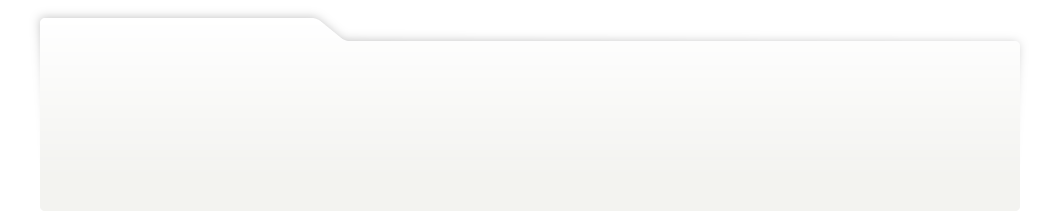
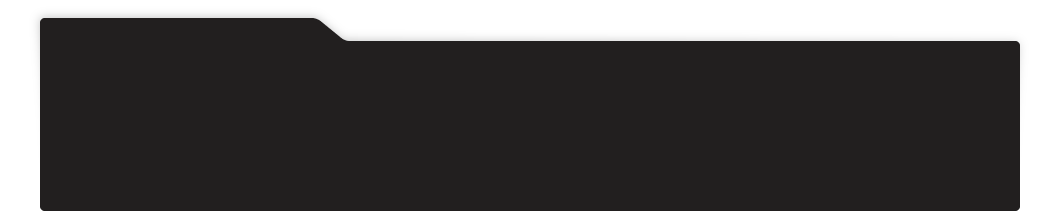
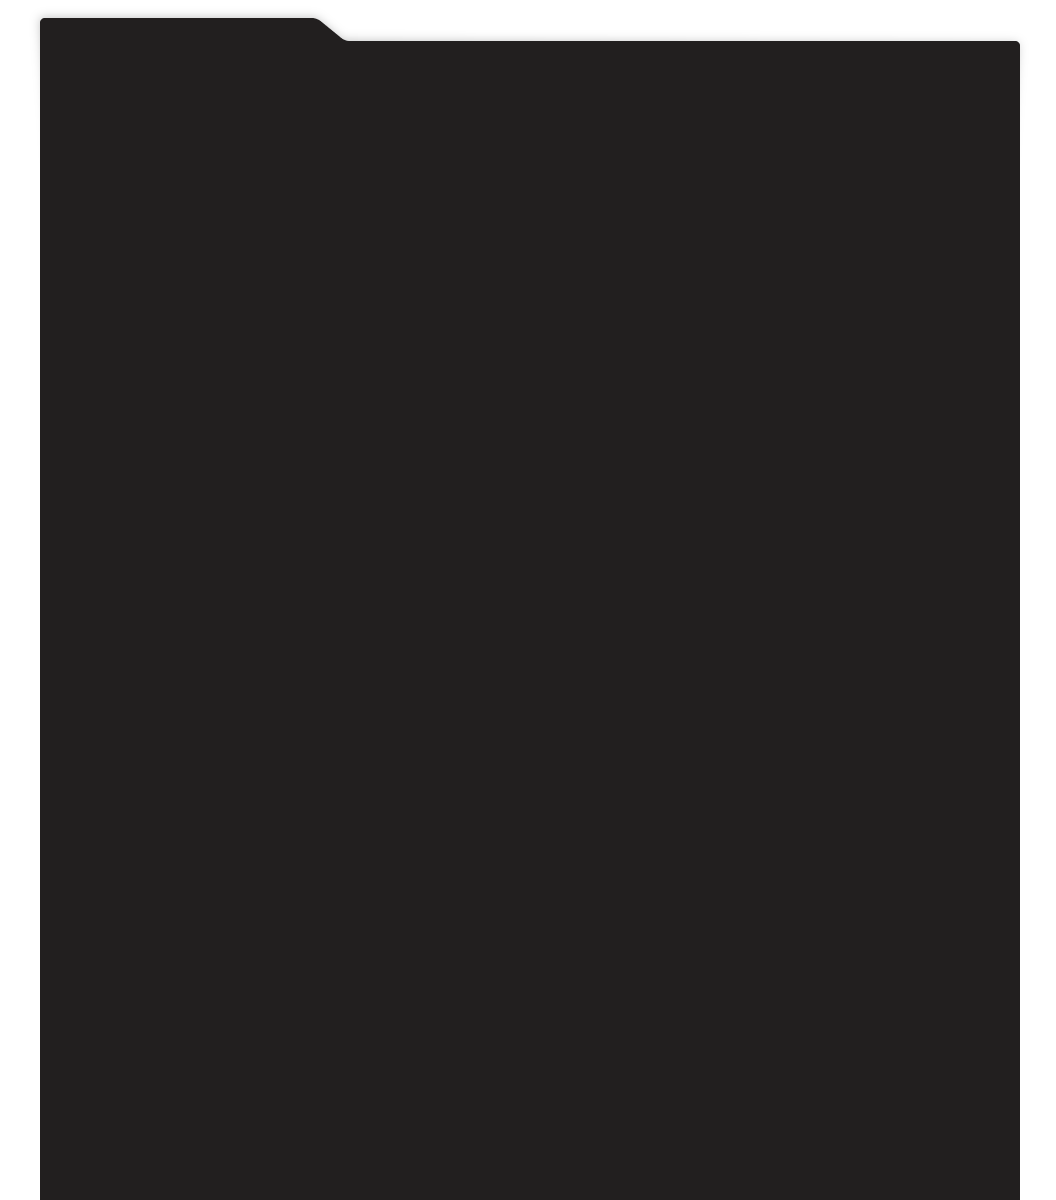
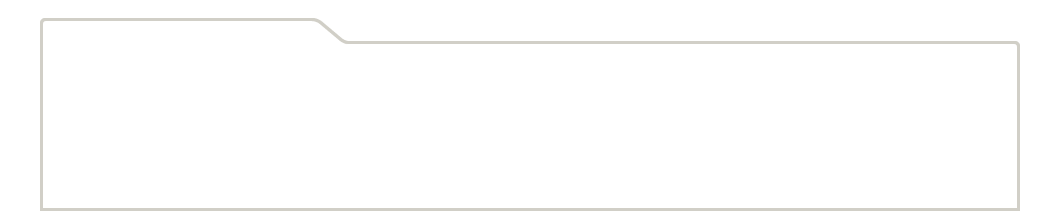
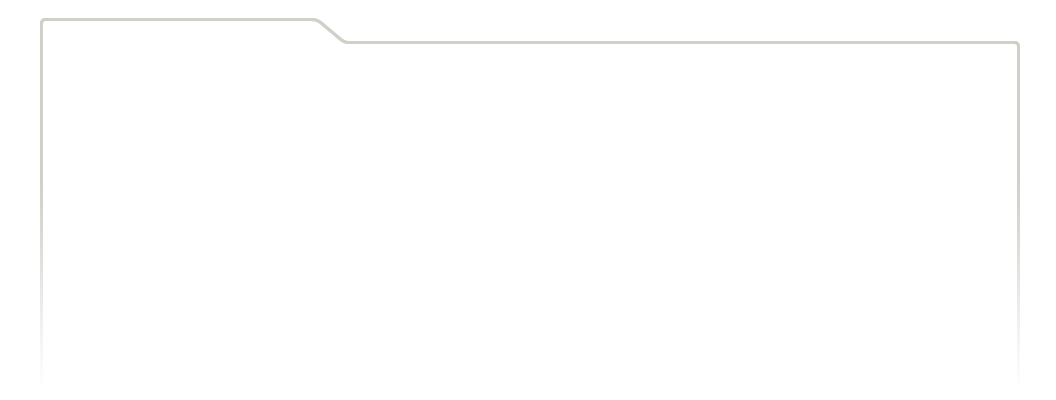
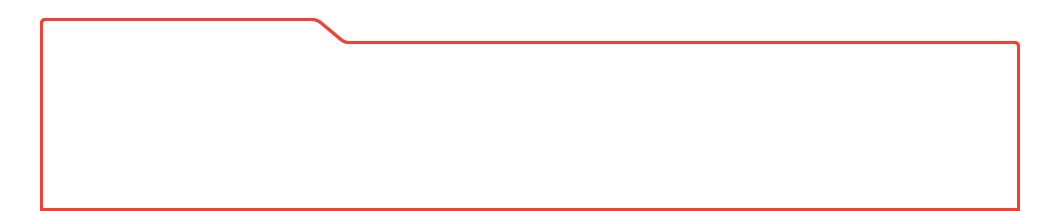
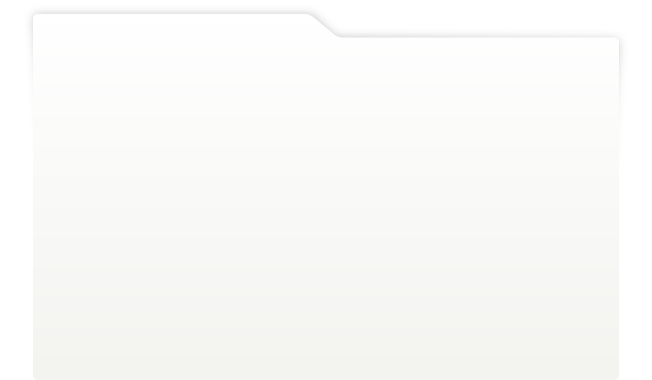
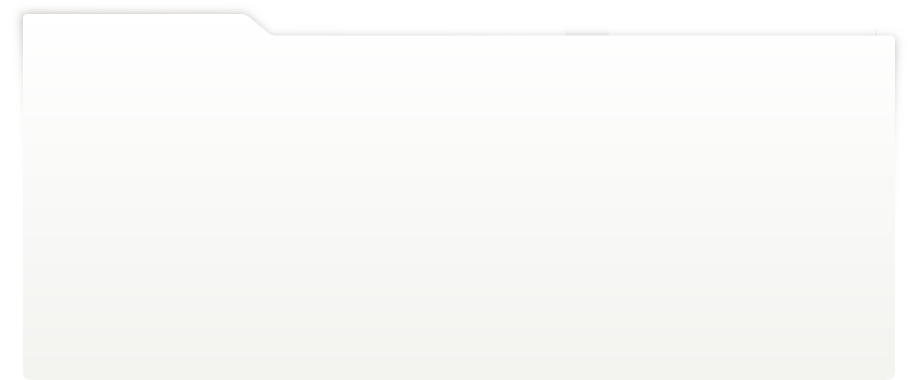
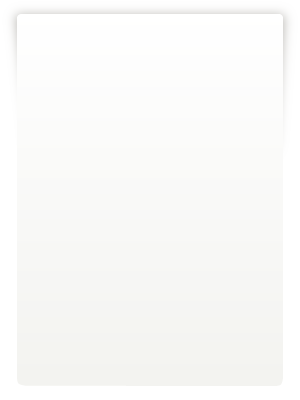
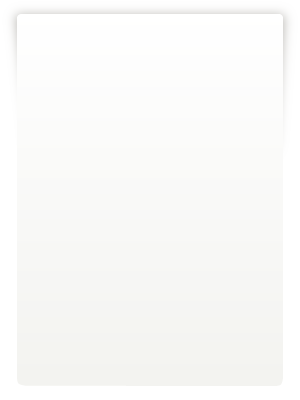
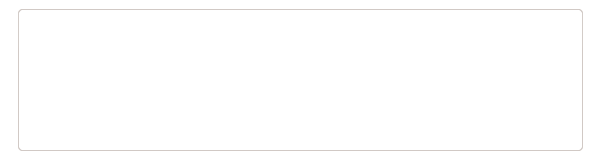
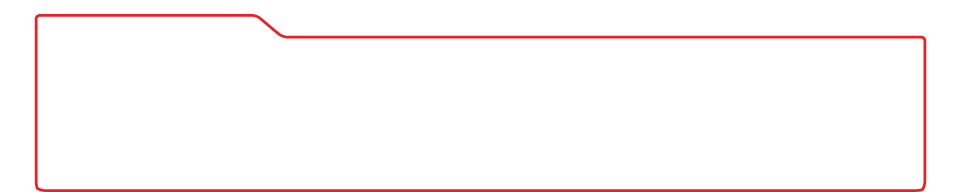
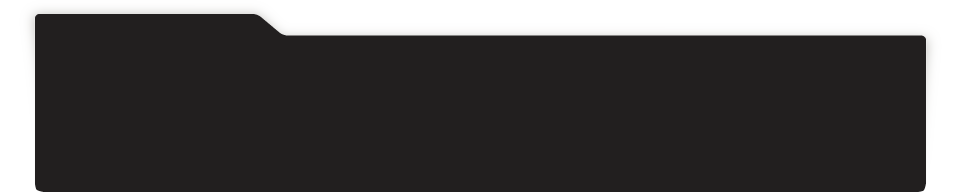
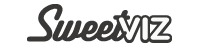
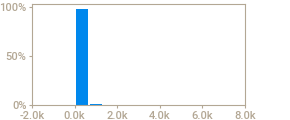
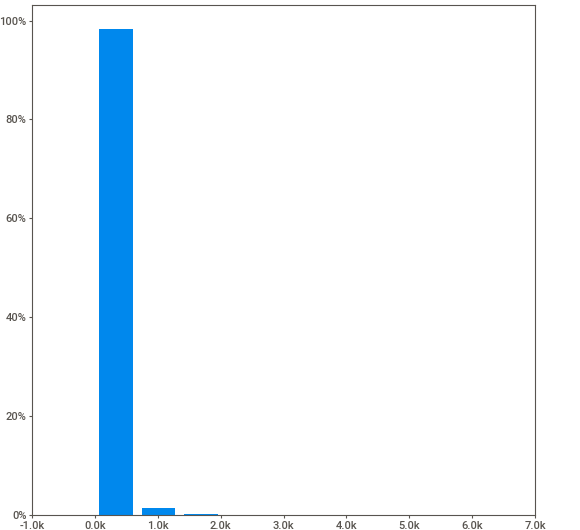
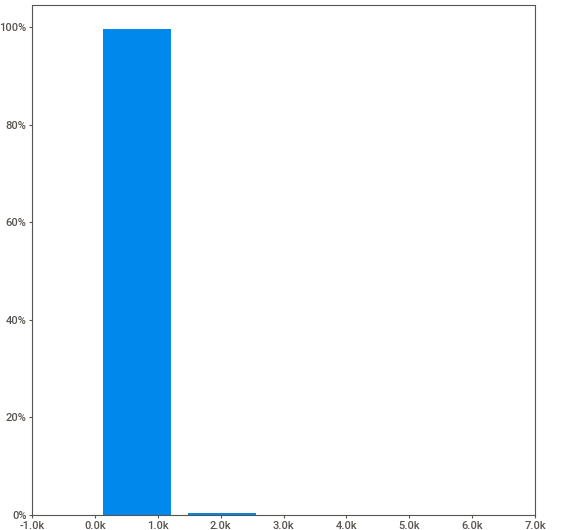
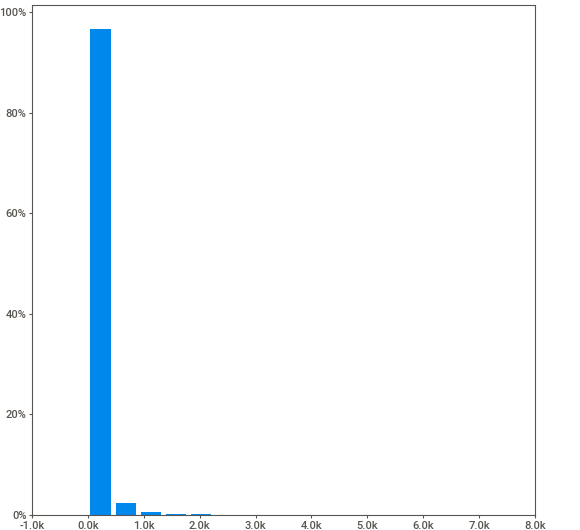
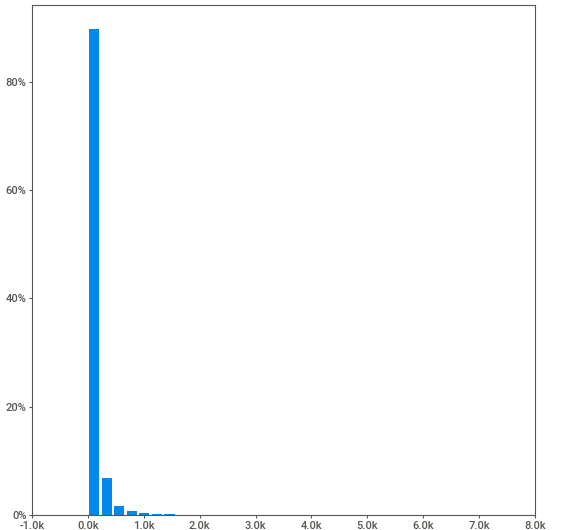
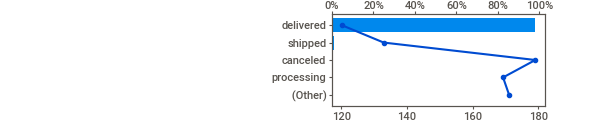
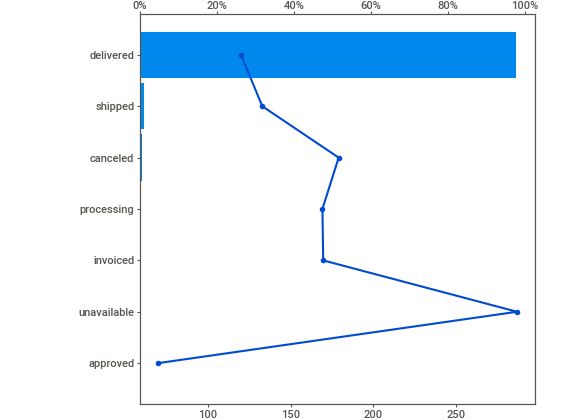
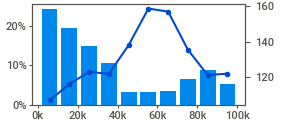
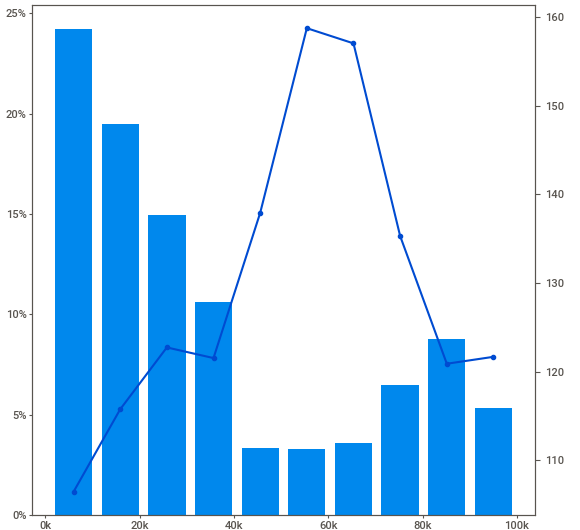
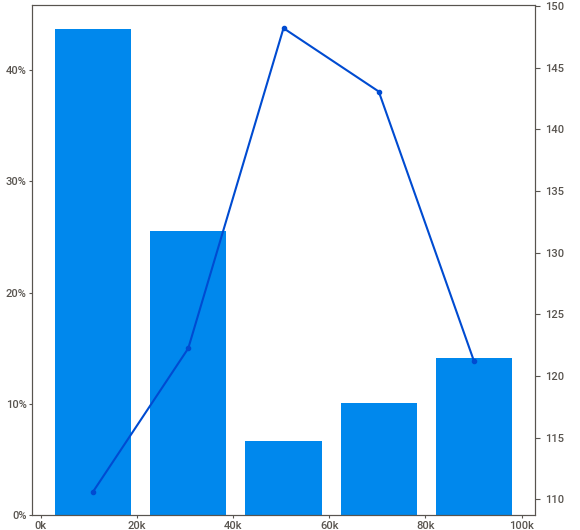
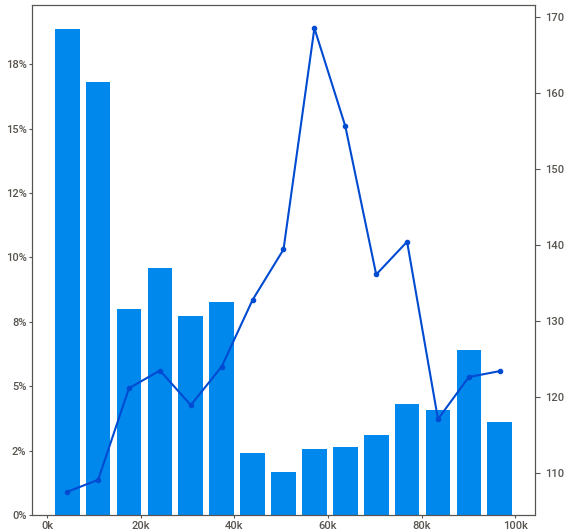
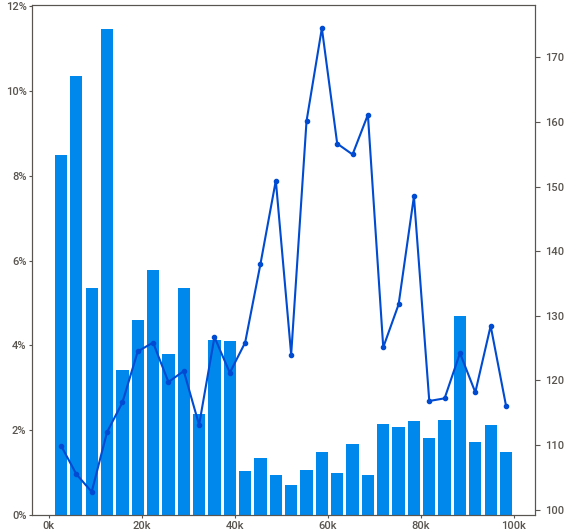
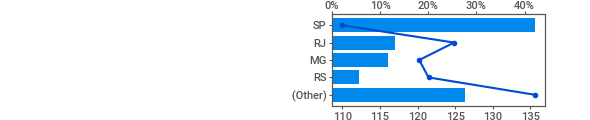
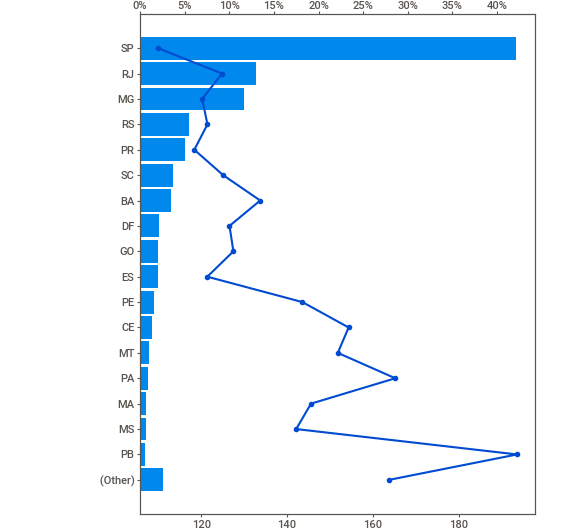
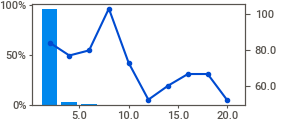
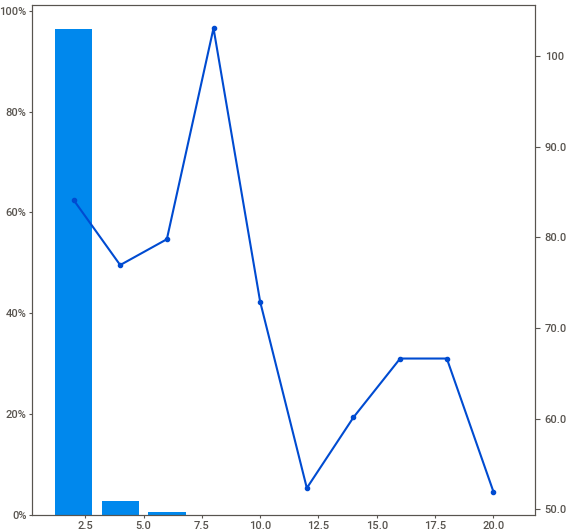
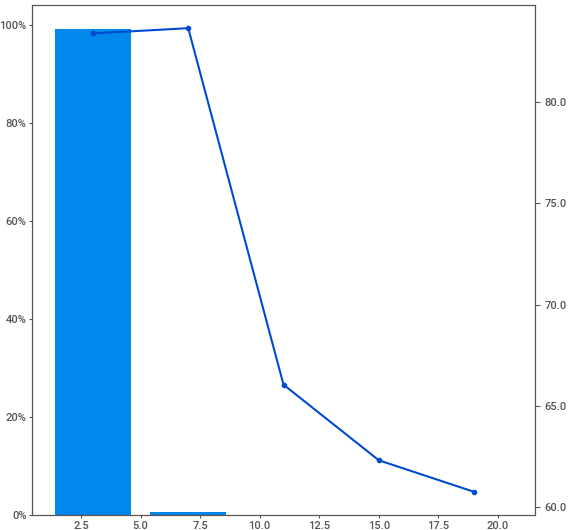
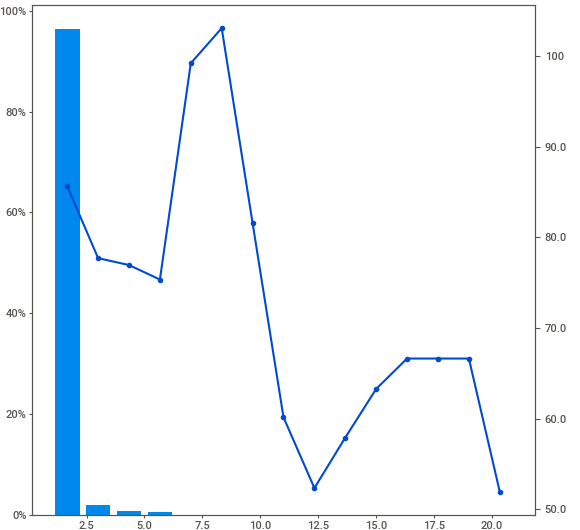
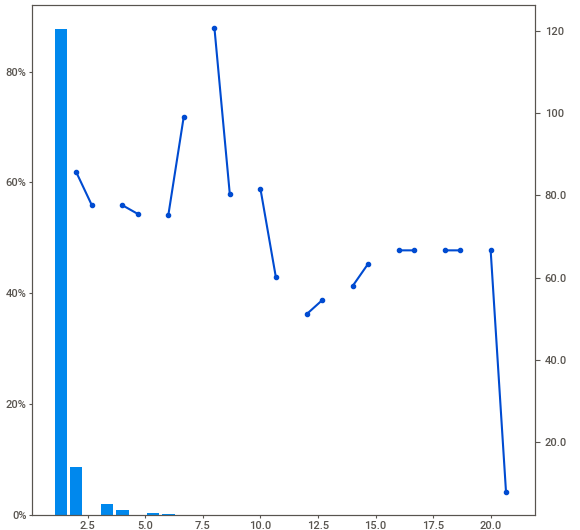
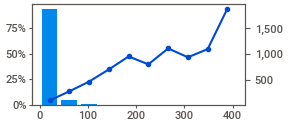
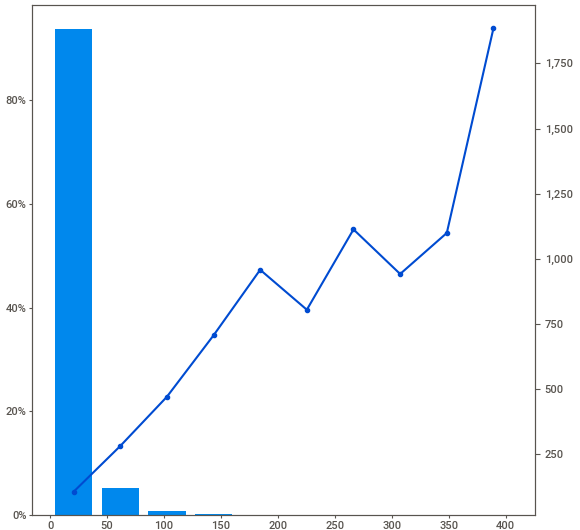
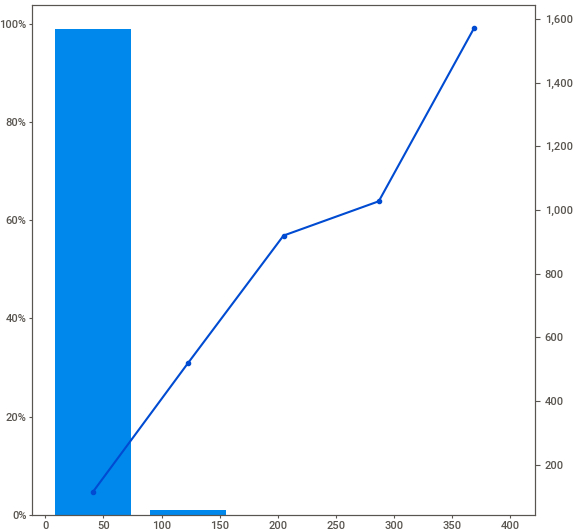
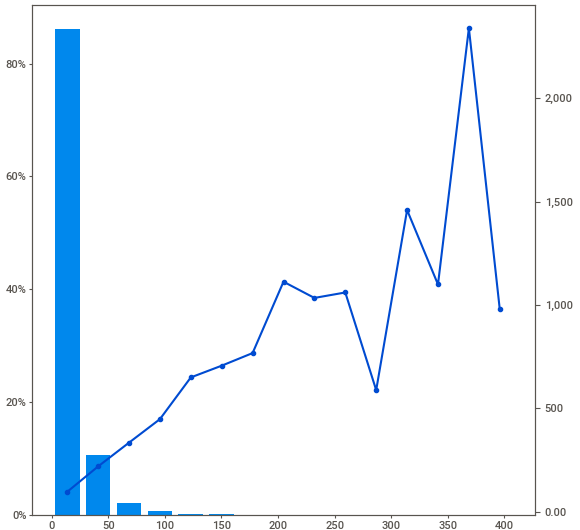
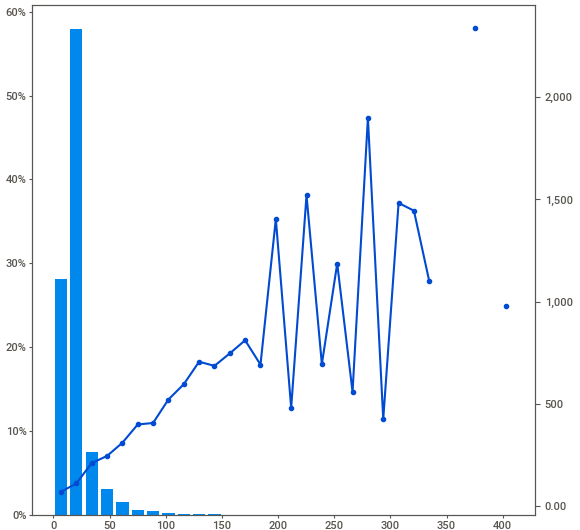
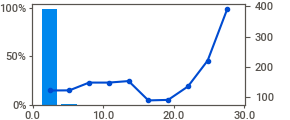
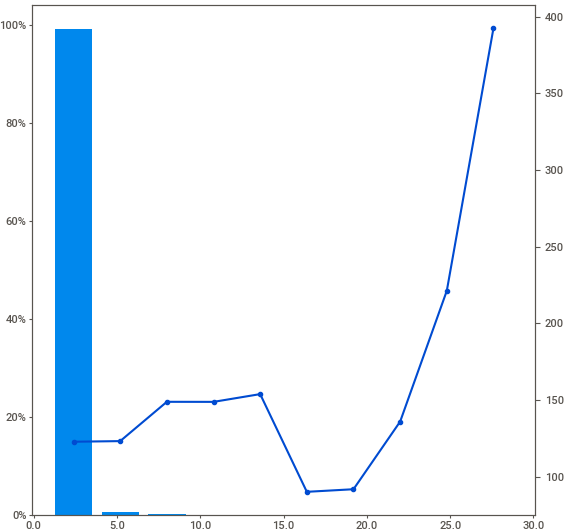
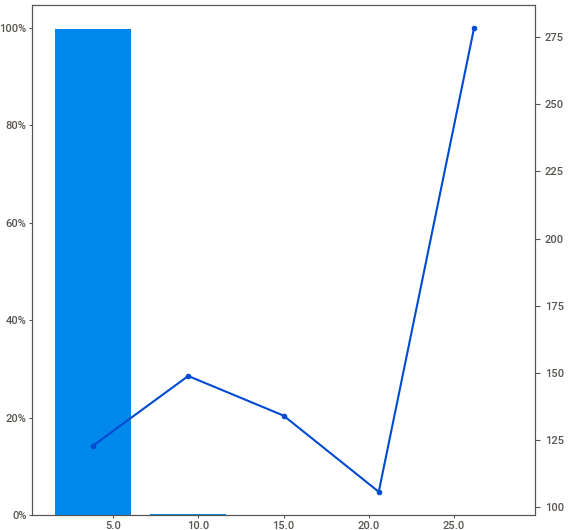
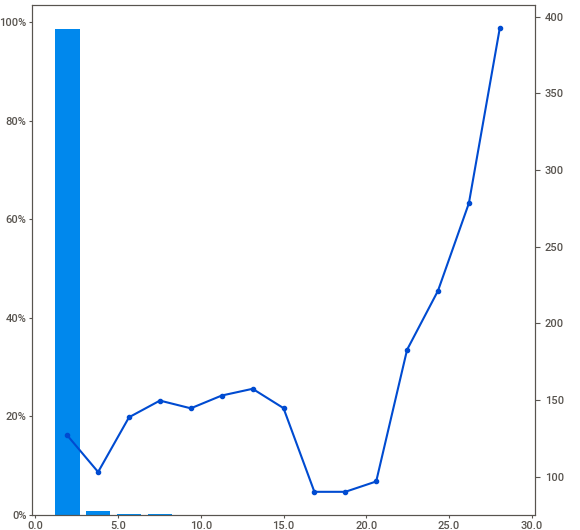
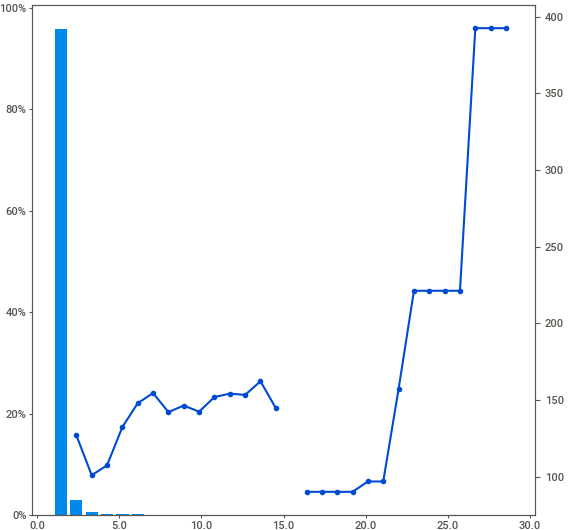
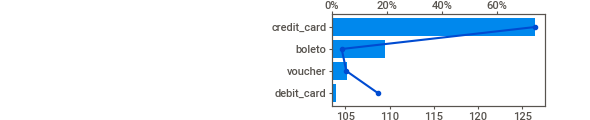
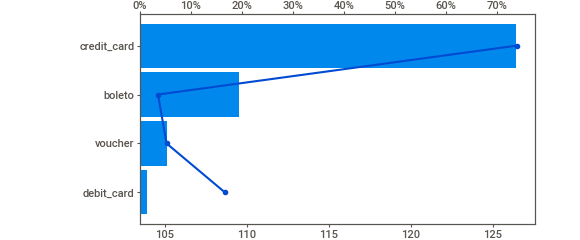
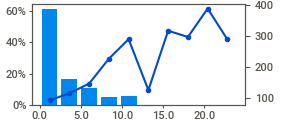
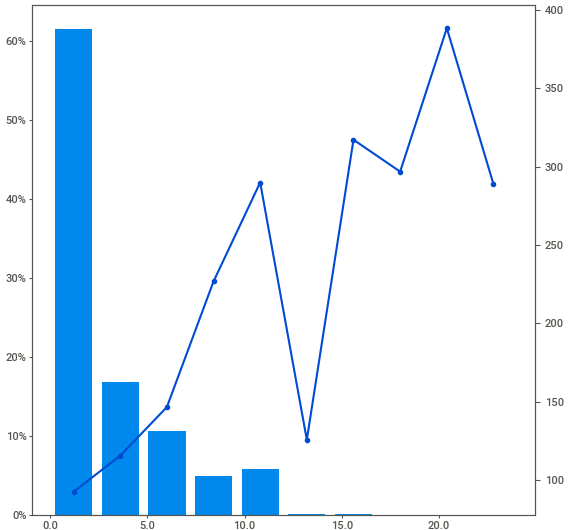
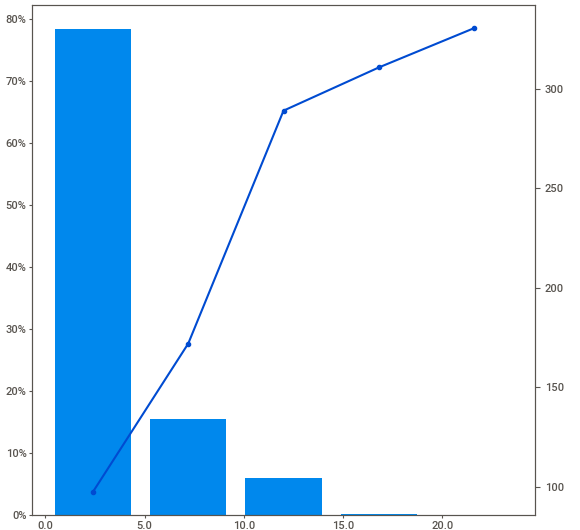
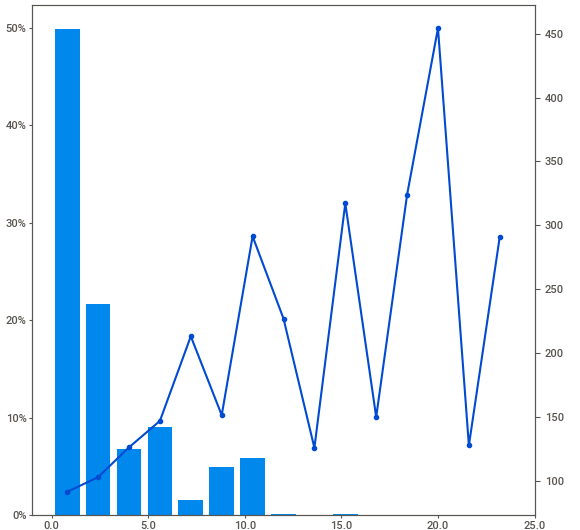
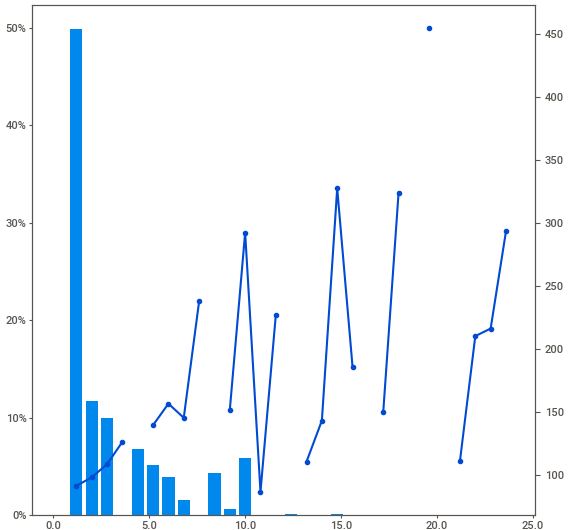
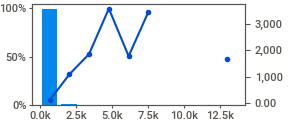
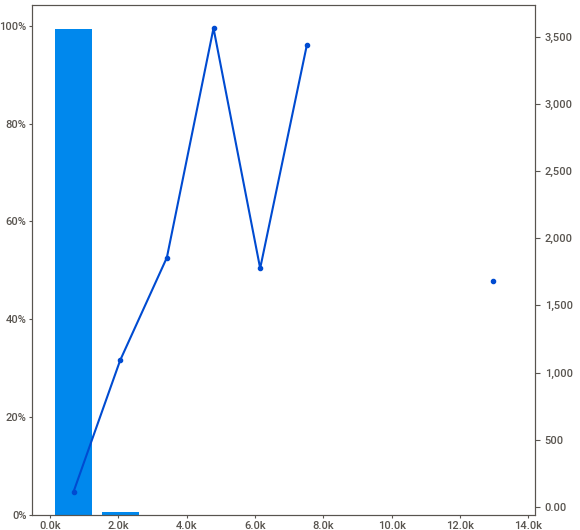
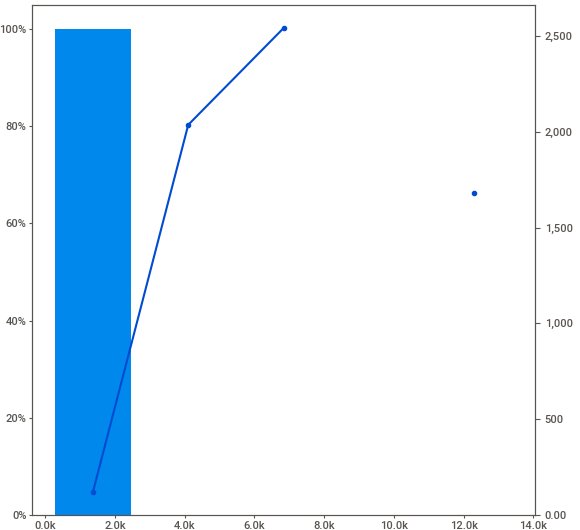
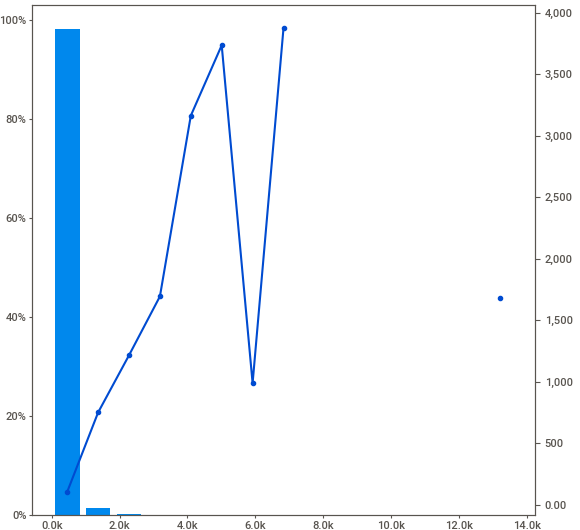
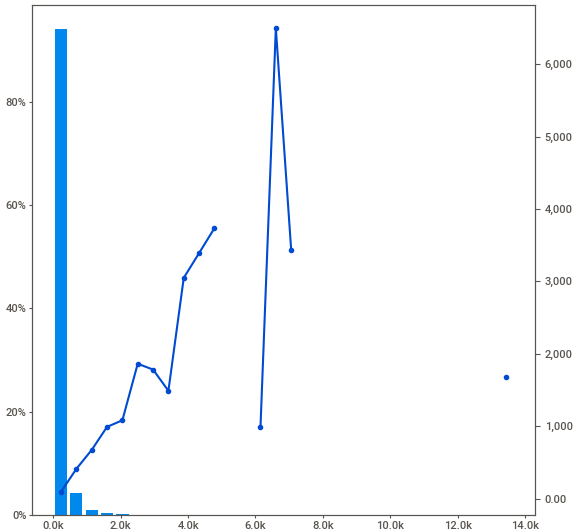
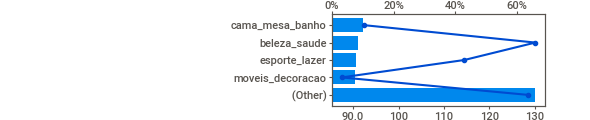
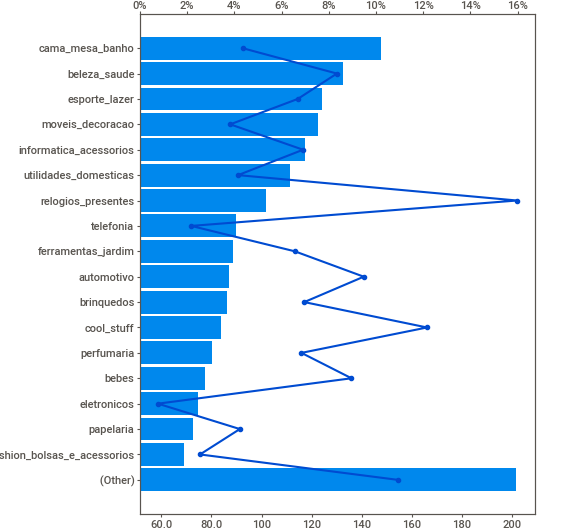
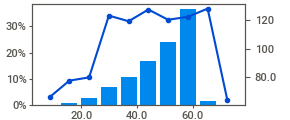
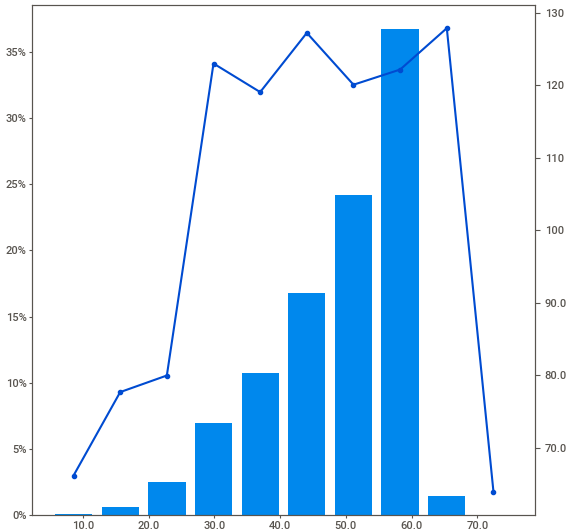
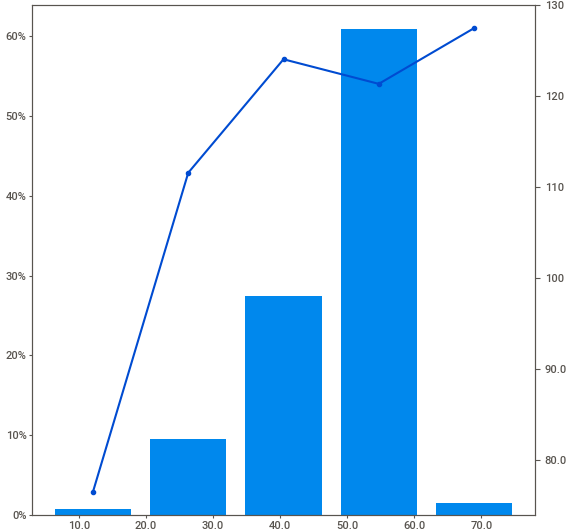
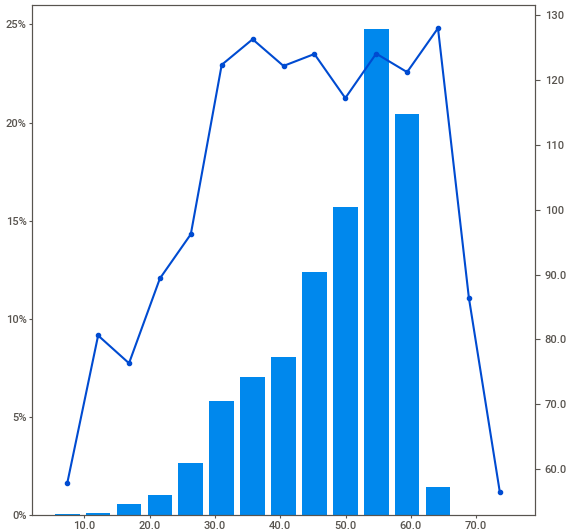
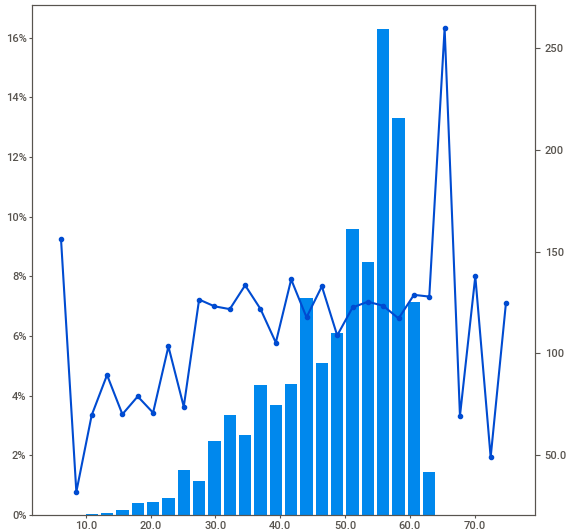
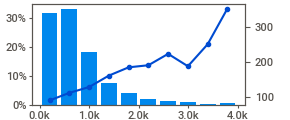
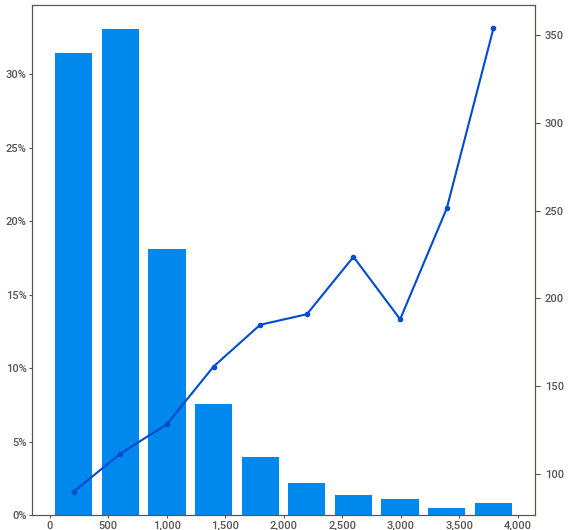
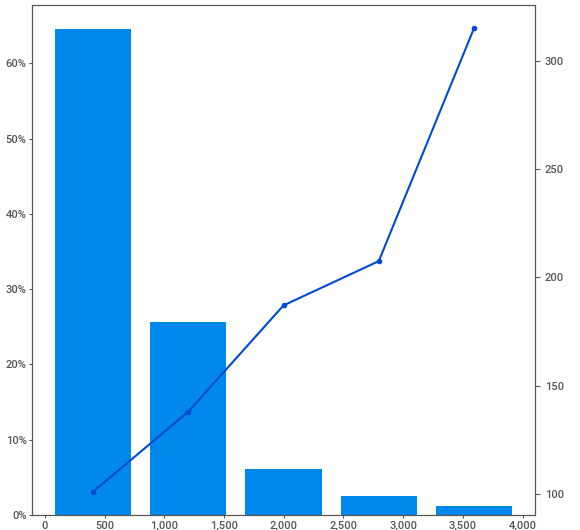
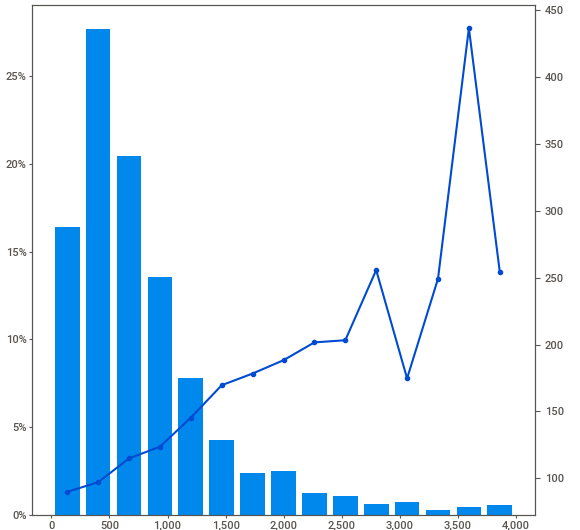
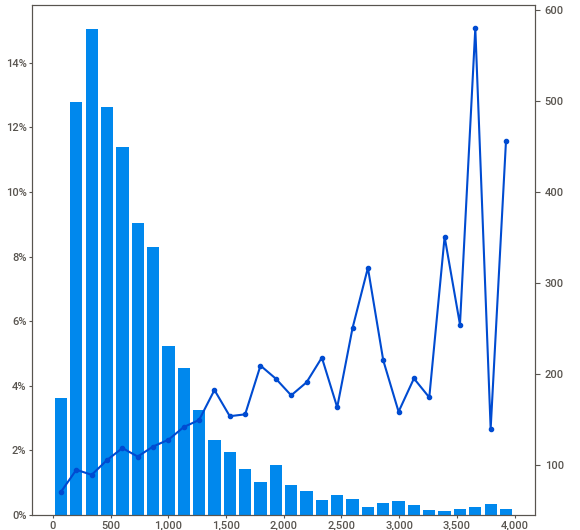
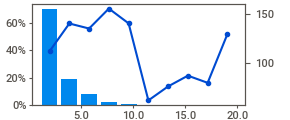
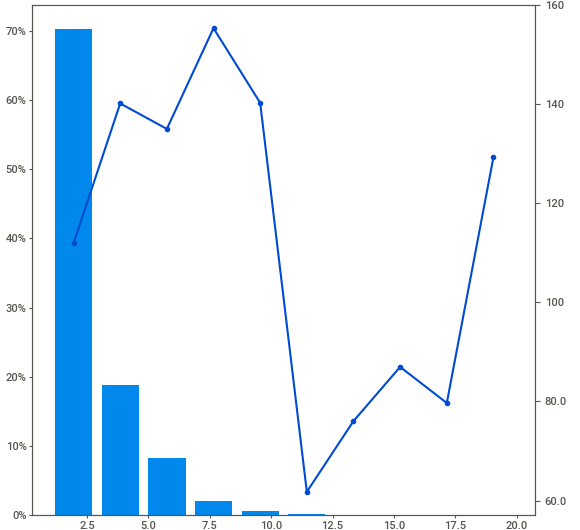
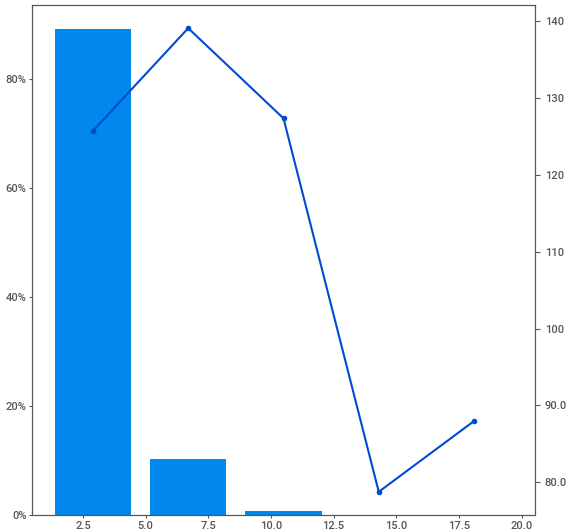
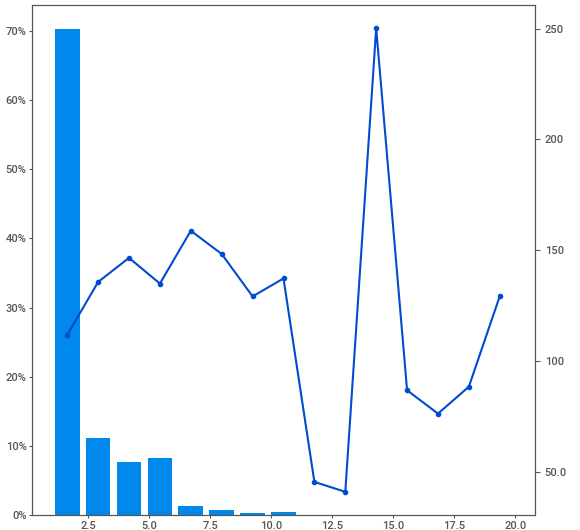
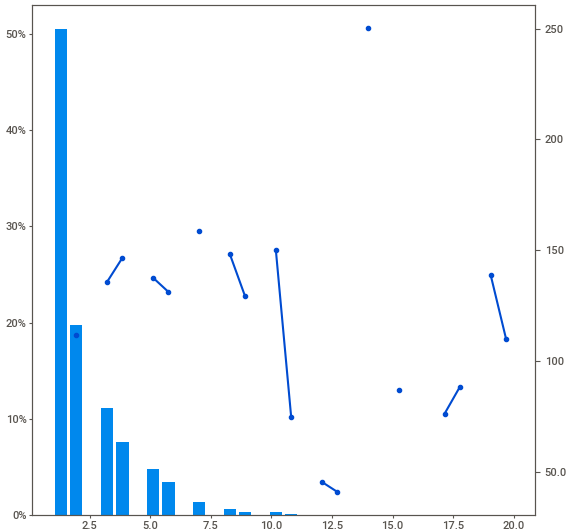
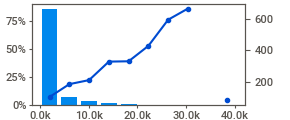
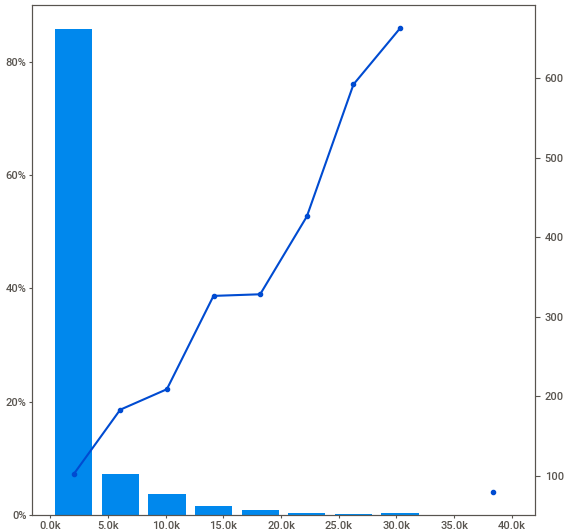
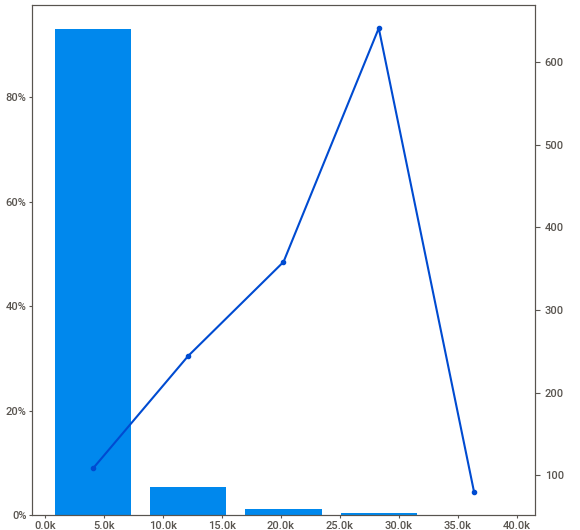
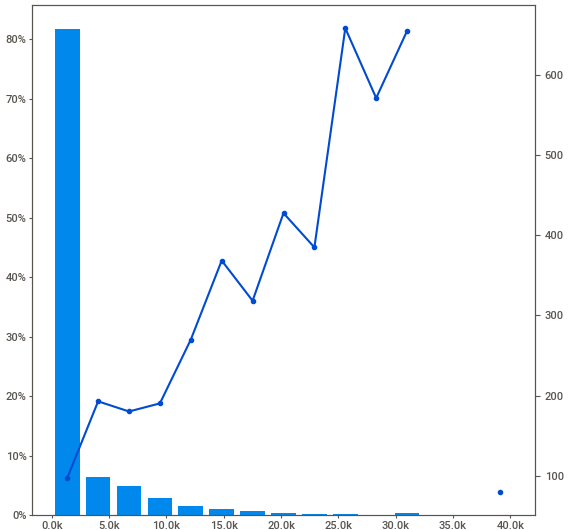
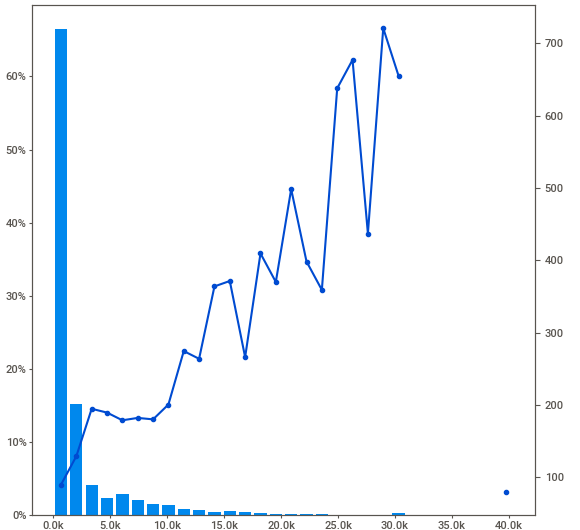
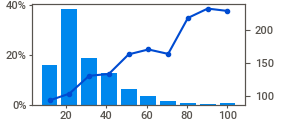
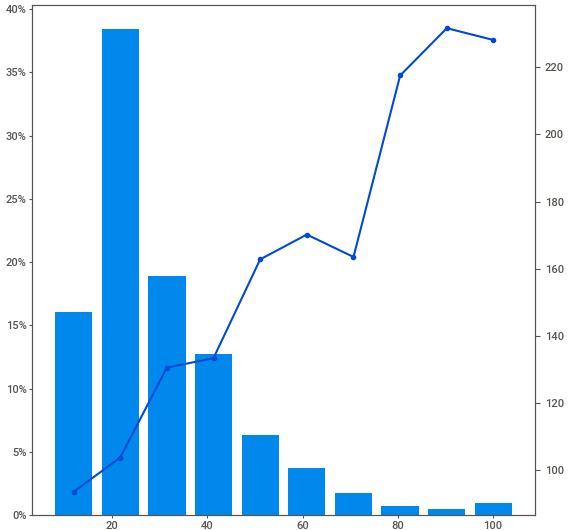
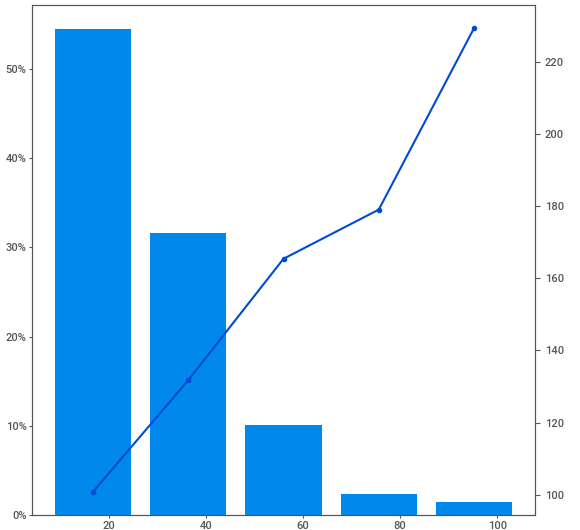
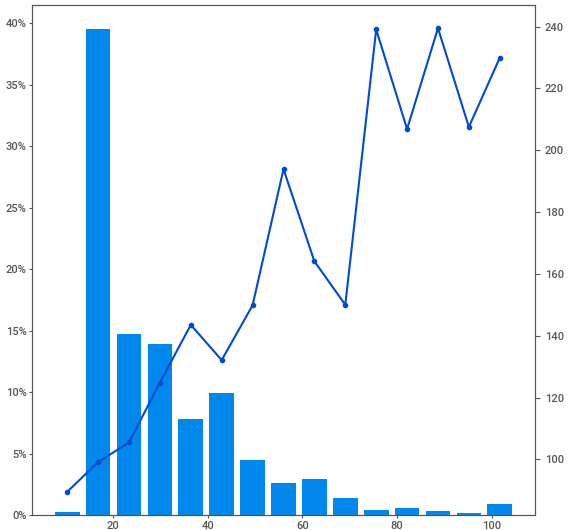
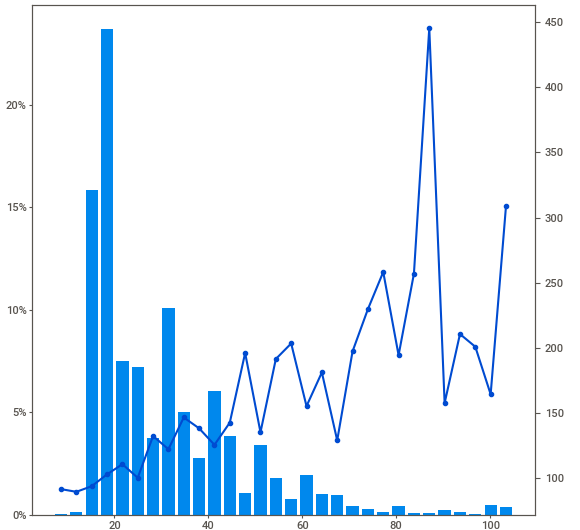
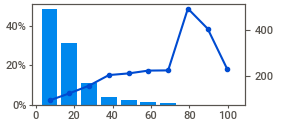
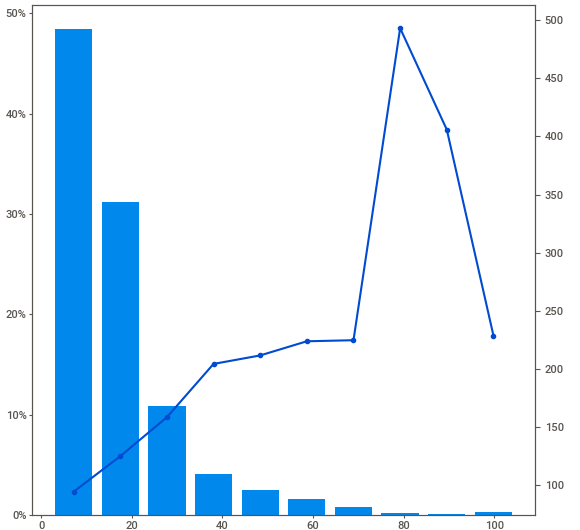
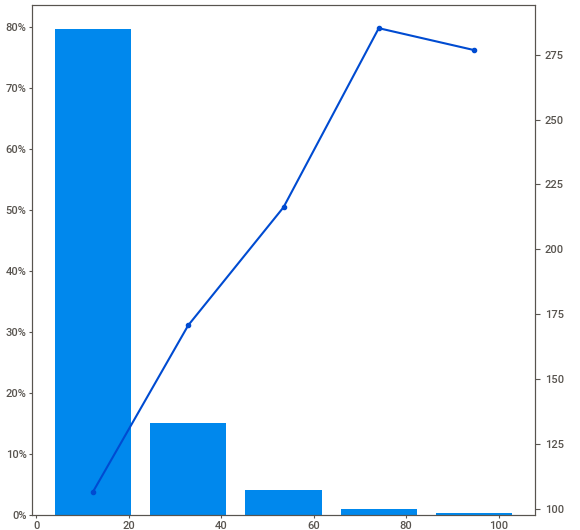
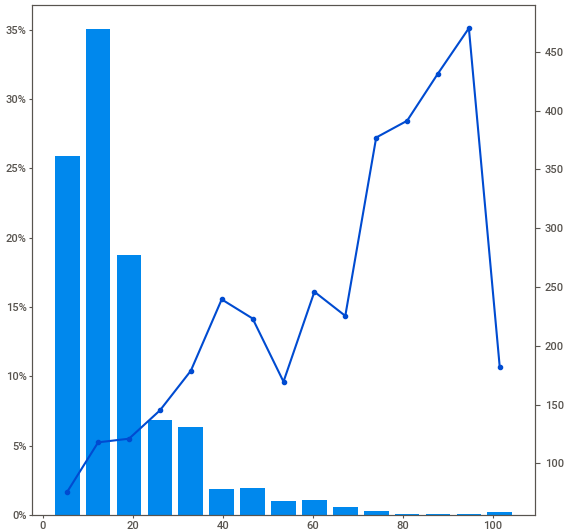
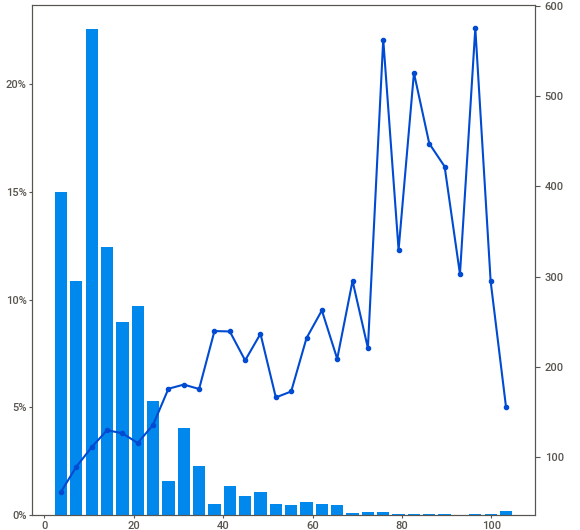
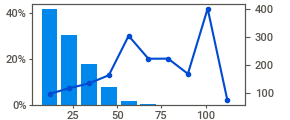
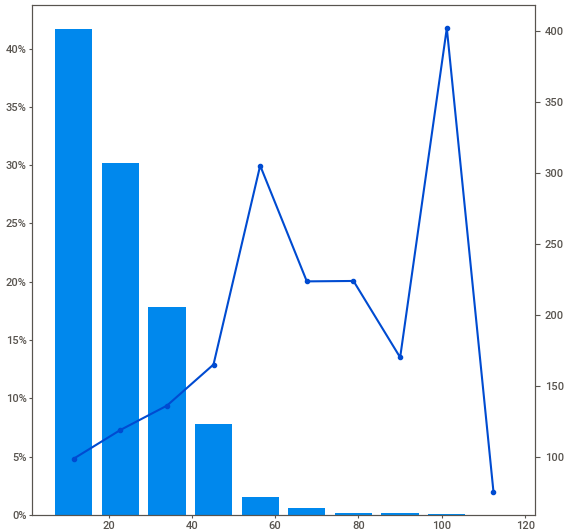
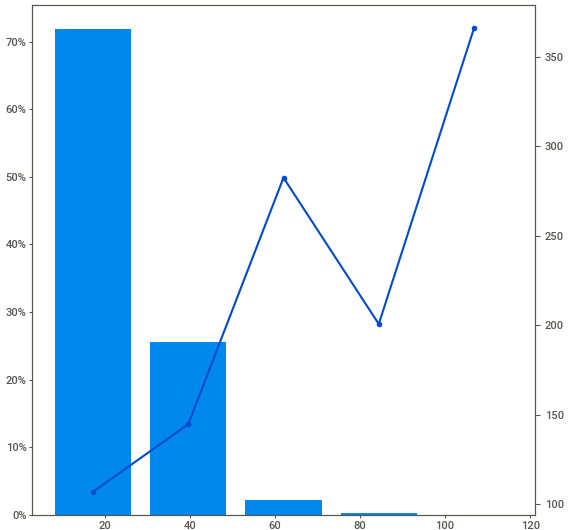
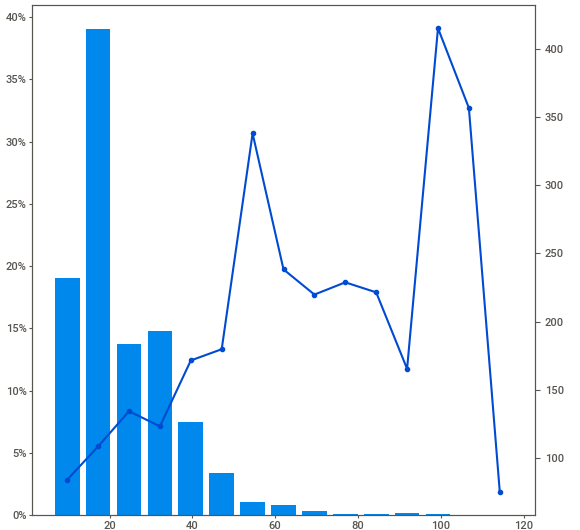
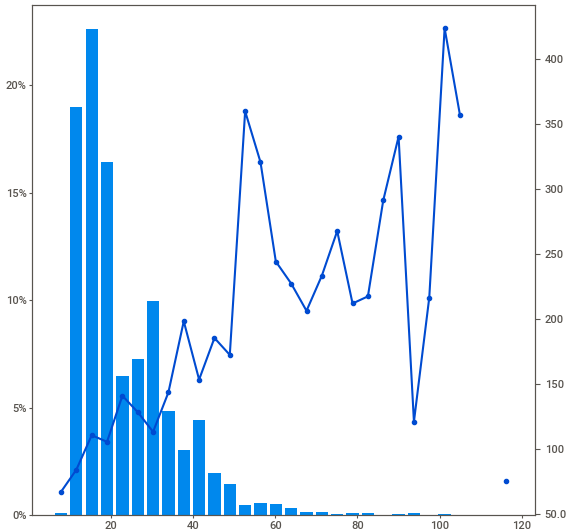
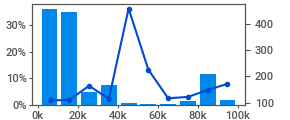
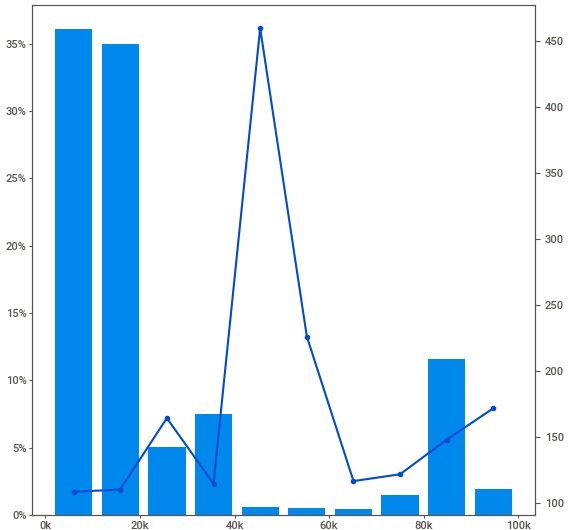
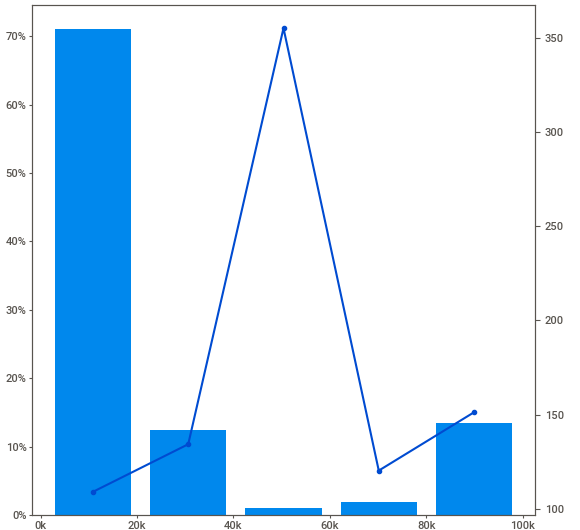
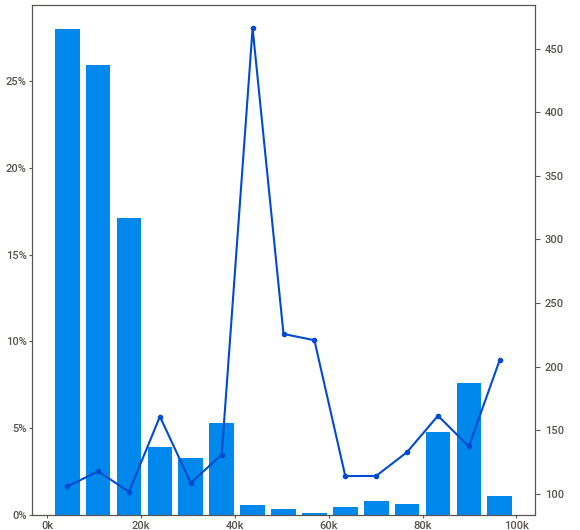
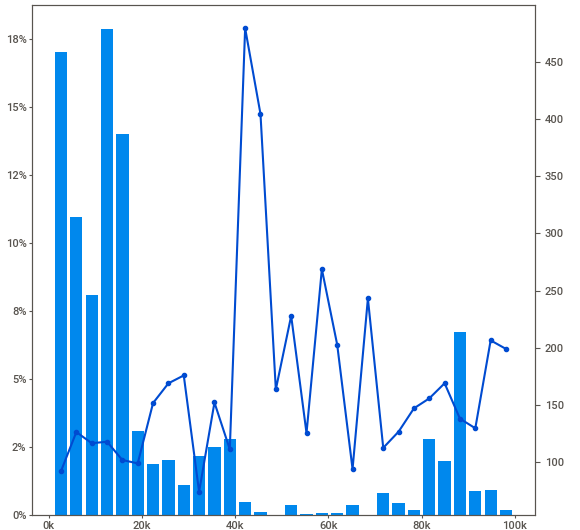
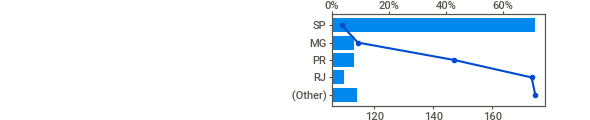
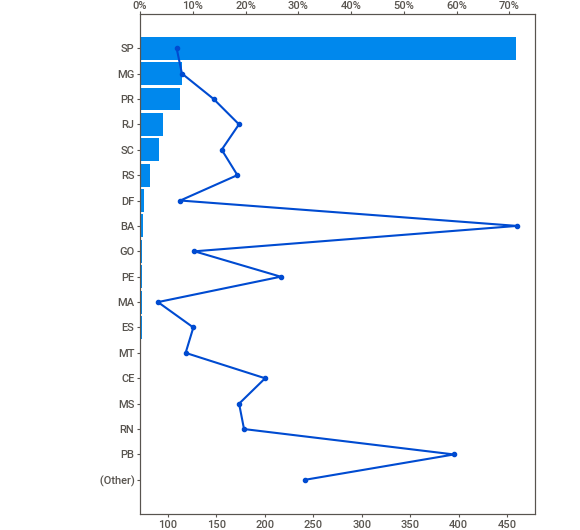
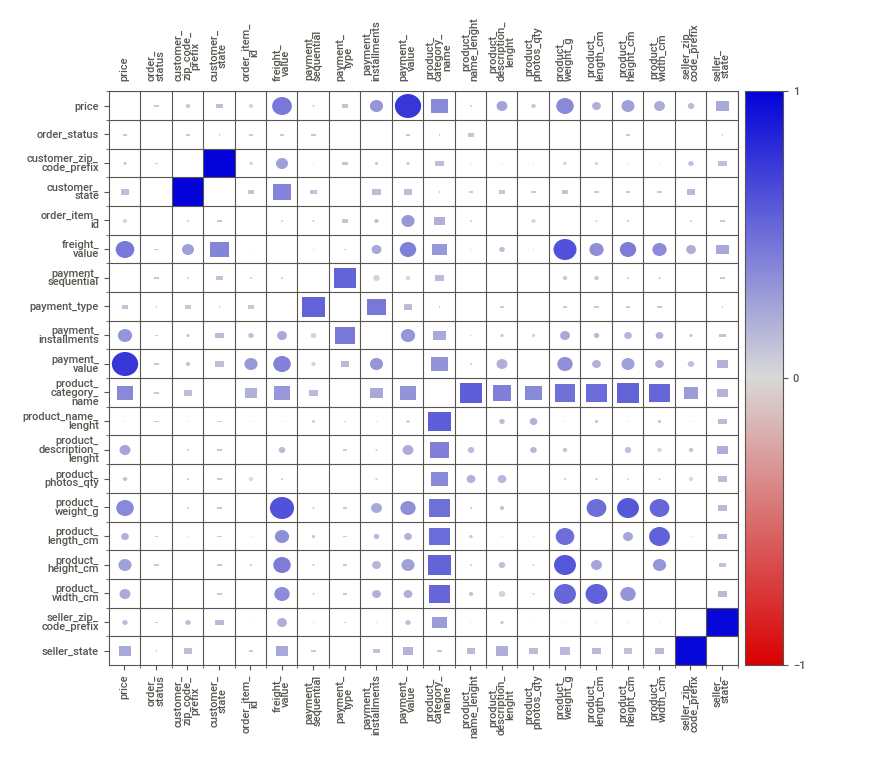
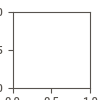

In [ ]:
my_report.show_notebook()

### Analysis based on sweetviz
### 1. Price depends mostly on Freight value, Seller state, Category name amongst others
### 2. Cancelled orders seem to have the highest price
### 3. Credit card users have spent the highest (high price)
### 4. relogios_presentes prodcut category has the highest price

In [ ]:
# Lets filter out only the delivered orders
df_delivered = df.query('order_status == "delivered"')

In [ ]:
missing_values_in_df(df_delivered)

total_missing_values  percent_missing_values
product_name_lenght                            1628                1.415221
product_category_name                          1628                1.415221
product_photos_qty                             1628                1.415221
product_description_lenght                     1628                1.415221
product_length_cm                                20                0.017386
product_width_cm                                 20                0.017386
product_height_cm                                20                0.017386
product_weight_g                                 20                0.017386
order_approved_at                                15                0.013040
order_delivered_customer_date                     8                0.006954
order_delivered_carrier_date                      2                0.001739
payment_installments                              0                0.000000
payment_value                                     0                0.000000
order_id                                          0                0.000000
payment_sequential                                0                0.000000
seller_zip_code_prefix                            0                0.000000
seller_city                                       0                0.000000
payment_type                                      0                0.000000
price                                             0                0.000000
freight_value                                     0                0.000000
customer_id                                       0                0.000000
shipping_limit_date                               0                0.000000
seller_id                                         0                0.000000
product_id                                        0                0.000000
order_item_id                                     0                0.000000
customer_state                                    0                0.000000
customer_city                                     0                0.000000
customer_zip_code_prefix                          0                0.000000
customer_unique_id                                0                0.000000
order_estimated_delivery_date                     0                0.000000
order_purchase_timestamp                          0                0.000000
order_status                                      0                0.000000
seller_state                                      0                0.000000

In [ ]:
#Check for duplicated orders (if they exist we will remove them)
print(df.duplicated().value_counts()) #None 

False    117601
dtype: int64


# 3. Create variables recency, frequency and amount 

In [7]:
#To create the RFM we use the max date of Delivered orders just like we mentioned above
last_date = df['order_delivered_carrier_date'].max() + pd.to_timedelta(1, 'D')

RFM = df.dropna(subset=['order_delivered_carrier_date'])\
            .reset_index()\
            .groupby('customer_id')\
            .agg(Recency = ('order_delivered_carrier_date', lambda x: (last_date - x.max()).days ),
                 Frequency = ('order_id', 'size'),
                 Monetary = ('payment_value', 'sum'))

In [ ]:
RFM.isna().sum()

Recency      0
Frequency    0
Monetary     0
dtype: int64

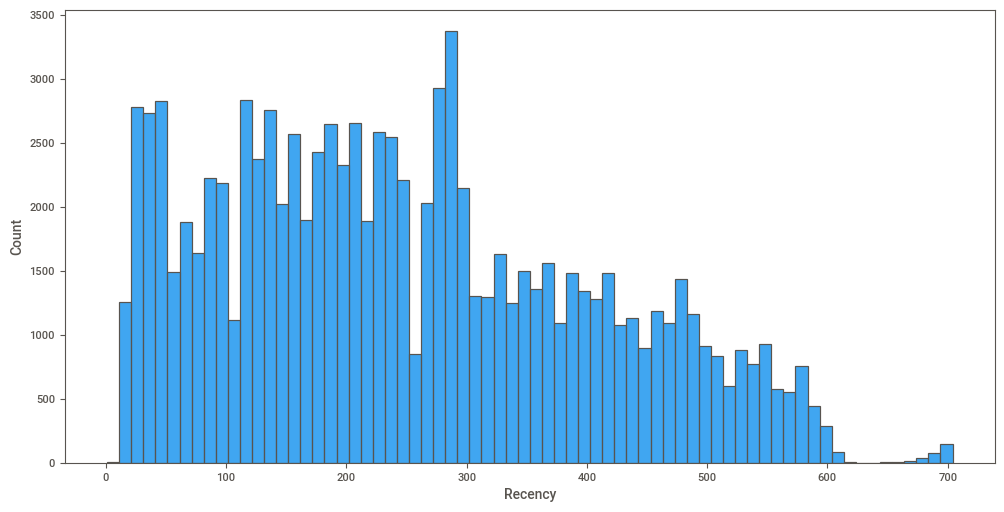

In [ ]:
#To plot Recency histogram
plt.figure(figsize=(12, 6))
sns.histplot(RFM['Recency'])
plt.show()

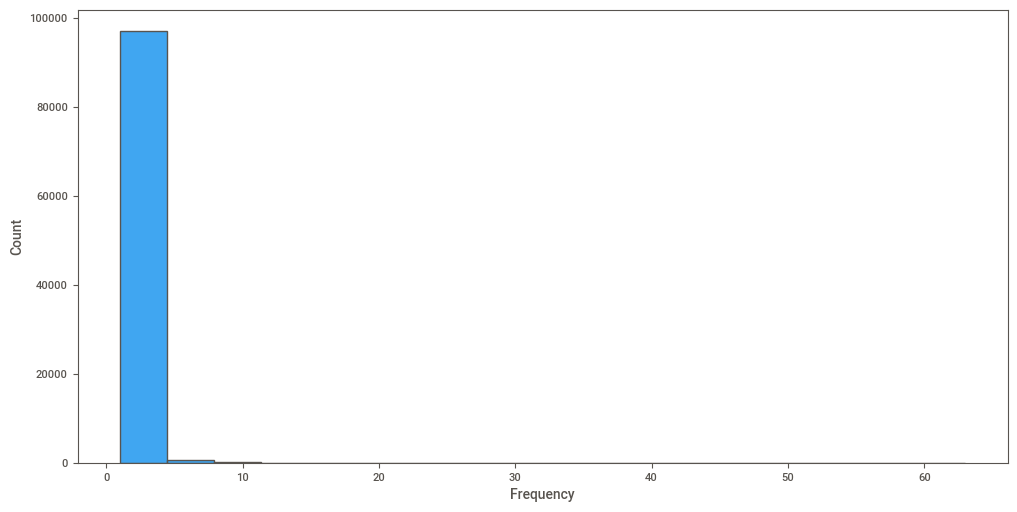

In [ ]:
#To plot Frequency histogram
plt.figure(figsize=(12, 6))
sns.histplot(RFM['Frequency'])
plt.show()

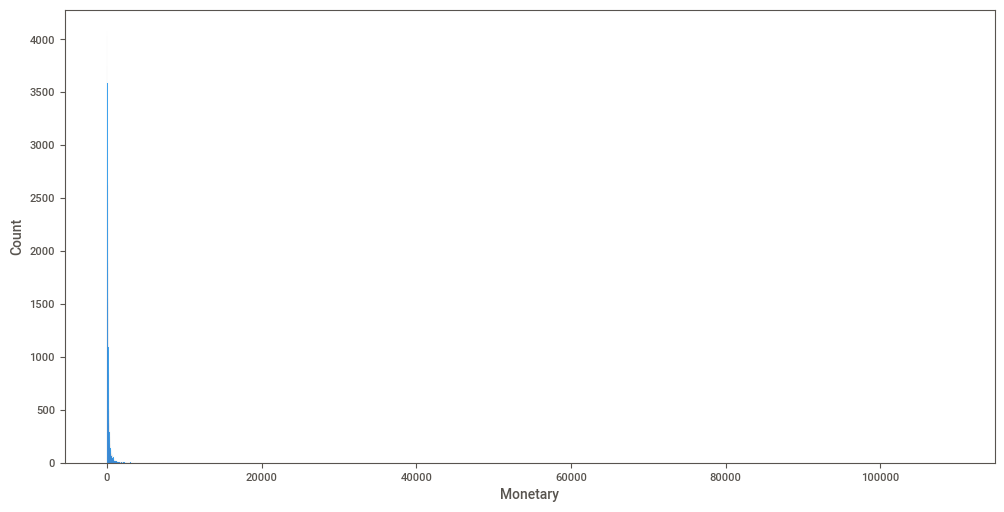

In [ ]:
#To plot Monetary value histogram
plt.figure(figsize=(12, 6))
sns.histplot(RFM['Monetary'])
plt.show()

In [ ]:
RFM.describe()

Recency     Frequency       Monetary
count  97656.000000  97656.000000   97656.000000
mean     250.503174      1.191488     204.614696
std      152.664113      0.734341     618.118614
min        1.000000      1.000000       9.590000
25%      127.000000      1.000000      62.680000
50%      231.000000      1.000000     109.420000
75%      361.000000      1.000000     195.332500
max      704.000000     63.000000  109312.640000

#### There seems to be outliers in both Monetary value and Frequency so we will try to remove them

In [ ]:
RFM.Frequency.value_counts(normalize=True).sort_values(ascending=False)

1     0.873761
2     0.095580
3     0.015903
4     0.007875
6     0.002714
5     0.002447
7     0.000481
8     0.000328
12    0.000205
10    0.000143
11    0.000123
9     0.000113
15    0.000061
14    0.000051
24    0.000041
13    0.000041
20    0.000031
21    0.000031
19    0.000010
22    0.000010
16    0.000010
26    0.000010
29    0.000010
38    0.000010
63    0.000010
Name: Frequency, dtype: float64

In [ ]:
RFM['Frequency'].apply(lambda x: 'less or equal to 6' if x<=6 else 'greater than 6')\
                .value_counts(normalize=True) * 100

less or equal to 6    99.827968
greater than 6         0.172032
Name: Frequency, dtype: float64

### So we only keep Frequency <=6 as it accounts for 99.6 % of the data

In [8]:
RFM = RFM[RFM['Frequency'] <= 6]

In [ ]:
RFM.describe([0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]).T

count        mean         std   min     1%     5%     10%  \
Recency    97656.0  250.503174  152.664113  1.00  21.00  35.00  54.000   
Frequency  97656.0    1.191488    0.734341  1.00   1.00   1.00   1.000   
Monetary   97656.0  204.614696  618.118614  9.59  22.38  32.38  39.625   

              25%     50%       75%     90%       95%        99%        max  
Recency    127.00  231.00  361.0000  478.00  532.0000   587.0000     704.00  
Frequency    1.00    1.00    1.0000    2.00    2.0000     4.0000      63.00  
Monetary    62.68  109.42  195.3325  383.04  634.6725  1633.7115  109312.64

<AxesSubplot:xlabel='Monetary'>

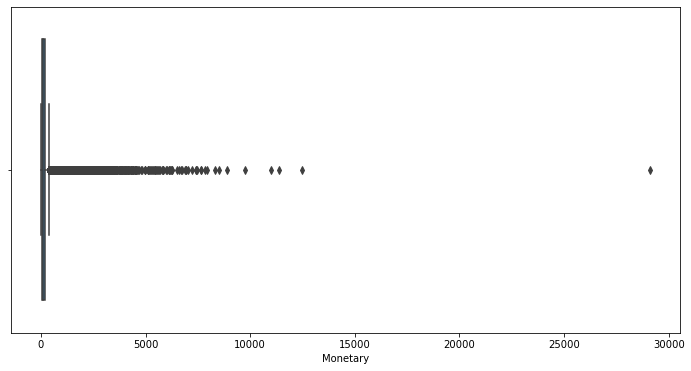

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='Monetary',data=RFM) #there's an outlier here in the 99 percentile so we will remove it

<AxesSubplot:title={'center':'Distribution of Monetary < 95%'}, xlabel='Monetary', ylabel='Density'>

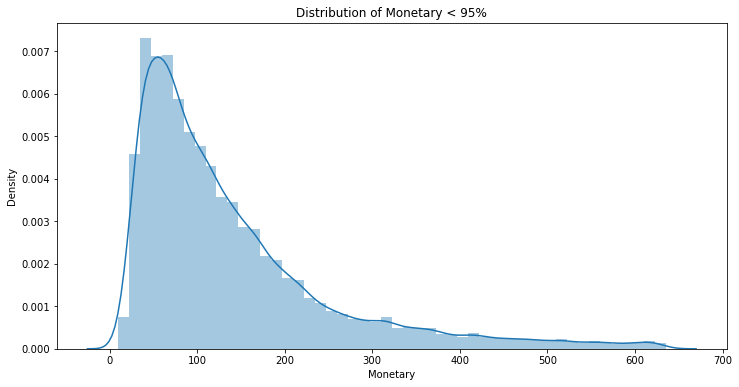

In [ ]:
plt.figure(figsize=(12, 6))
plt.title('Distribution of Monetary < 95%')
sns.distplot(RFM[RFM['Monetary']<635].Monetary) #so if we remove the outlier then the distribution is acceptable (using 635 as it the 95th percentile)

In [9]:
RFM = RFM[RFM['Monetary'] < 635]

<AxesSubplot:xlabel='Recency'>

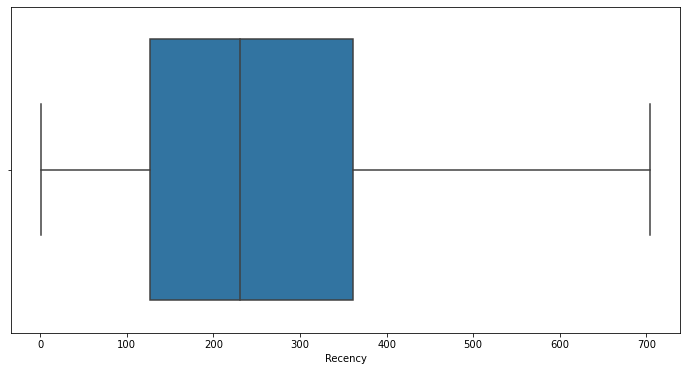

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='Recency', data=RFM) #No outliers here

# 4 Choose the variables of interest in your dataset and create your segmentation dataset

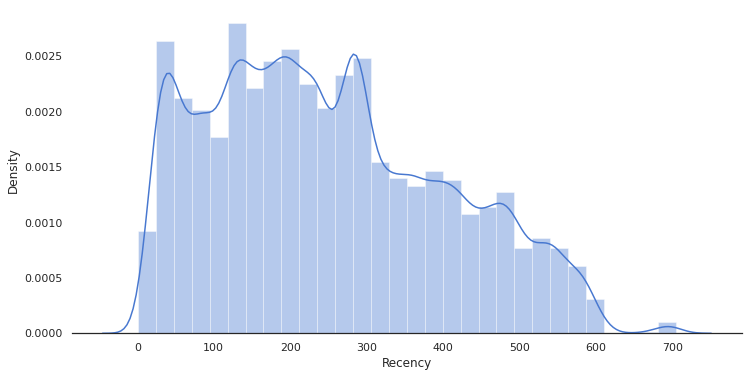

In [ ]:
# Distribution of Recency 
sns.set(palette='muted', color_codes=True, style='white')
fig, ax = plt.subplots(figsize=(12, 6))
sns.despine(left=True)
sns.distplot(RFM['Recency'], bins=30)
plt.show()

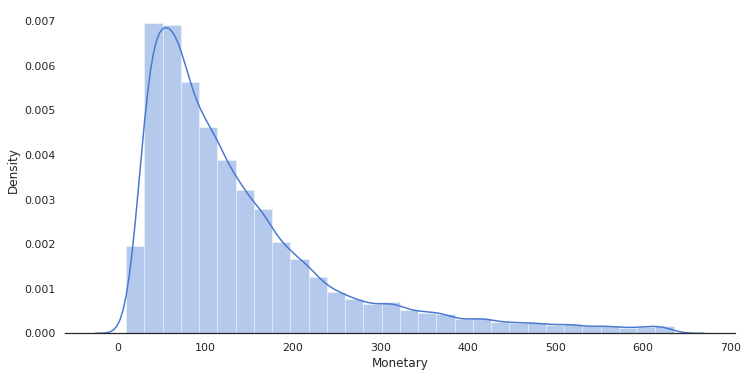

In [ ]:
#Distribution of Monetary Value
sns.set(palette='muted', color_codes=True, style='white')
fig, ax = plt.subplots(figsize=(12, 6))
sns.despine(left=True)
sns.distplot(RFM['Monetary'], bins=30)
plt.show()

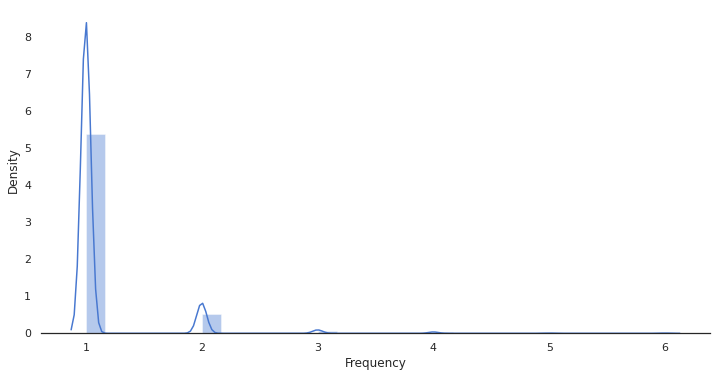

In [ ]:
#Distribution of Frequency
sns.set(palette='muted', color_codes=True, style='white')
fig, ax = plt.subplots(figsize=(12, 6))
sns.despine(left=True)
sns.distplot(RFM['Frequency'], bins=30)
plt.show()

# 5 Test Two different segmentation algorithms



In [ ]:
#function for ordering cluster numbers
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

In [10]:
#Standardize the data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

RFM_normalized = scaler.fit_transform(RFM)

## Model 1 : K-Means Clustering

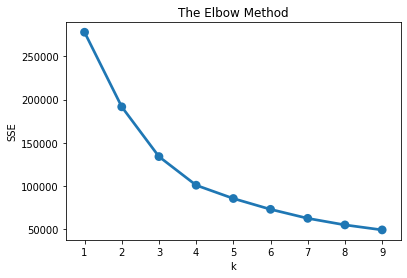

In [ ]:
from sklearn.cluster import KMeans
#To get the Elblow plot to find the optimal number of clusters
sse = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(RFM_normalized)
    sse[k] = kmeans.inertia_ 
    
plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

In [13]:
#From the elblow plot we choose 5 clusters
model = KMeans(n_clusters=5, random_state=42)
model.fit(RFM_normalized)
model.labels_.shape

(92696,)

In [ ]:
#To get the silhouette score of the chosen model
from sklearn.metrics import silhouette_score

s_score_k2 = silhouette_score(RFM_normalized, y_pred)

print(s_score_k2)

0.42923958375131893


In [14]:
#To plot the clusters using PCA
from sklearn.decomposition import PCA

y_pred = model.fit_predict(pd.DataFrame(RFM_normalized))

pca = PCA(n_components=2)
X_r = pca.fit_transform(pd.DataFrame(RFM_normalized))

In [25]:
#To get the number of customers in each cluster
for i in range(0,5):
    print(f"cluster {i} contains: {(np.sum(y_pred == i))} customers = {np.round((np.sum(y_pred == i)/92696)*100,decimals=1)} percent")

cluster 0 contains: 43108 customers = 46.5 percent
cluster 1 contains: 31552 customers = 34.0 percent
cluster 2 contains: 8081 customers = 8.7 percent
cluster 3 contains: 8558 customers = 9.2 percent
cluster 4 contains: 1397 customers = 1.5 percent


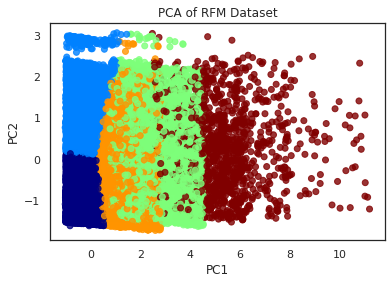

In [ ]:
plt.figure()

plt.scatter(X_r[:, 0], X_r[:, 1], c=y_pred, alpha=.8, cmap = 'jet')
plt.title('PCA of K-Means Cluster')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

#### The clusters seem to be ideal 

### Model 2 : DBSCAN

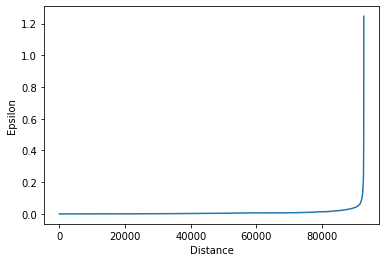

In [ ]:
# we use nearestneighbors for calculating distance between points (epsilon)
from sklearn.neighbors import NearestNeighbors
# calculating distances
neigh=NearestNeighbors(n_neighbors=2)
distance=neigh.fit(RFM_normalized)
# indices and distance values
distances,indices=distance.kneighbors(RFM_normalized)
# Now sorting the distance increasing order
sorting_distances=np.sort(distances,axis=0)
# sorted distances
sorted_distances=sorting_distances[:,1]
# plot between distance vs epsilon
plt.plot(sorted_distances)
plt.xlabel('Distance')
plt.ylabel('Epsilon')
plt.show()

In [ ]:
from sklearn.cluster import DBSCAN
# intializing DBSCAN with min_samples = 6 (ideally >2*number of features)
clustering_model=DBSCAN(eps=0.18,min_samples=6)

clustering_model.fit(RFM_normalized)

predicted_labels=clustering_model.labels_

In [ ]:
s_score_DB = silhouette_score(RFM_normalized, predicted_labels)

print(s_score_DB)

0.3311763557035678


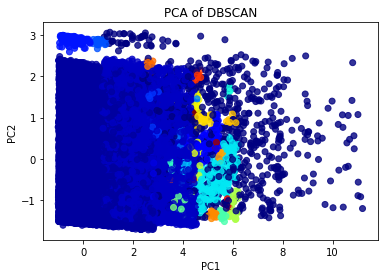

In [ ]:
#To plot the clusters formed with the DBSCAN Model using PCA
plt.figure()
plt.scatter(X_r[:, 0], X_r[:, 1], c=predicted_labels, alpha=.8, cmap = 'jet')
plt.title('PCA of DBSCAN cluster')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

### Visualizing using TSNE for better understanding of the Clusters generated by the Models

In [ ]:
#Plotting of the K-Means Cluster
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=100)
df_reduced = tsne.fit_transform(RFM_normalized)


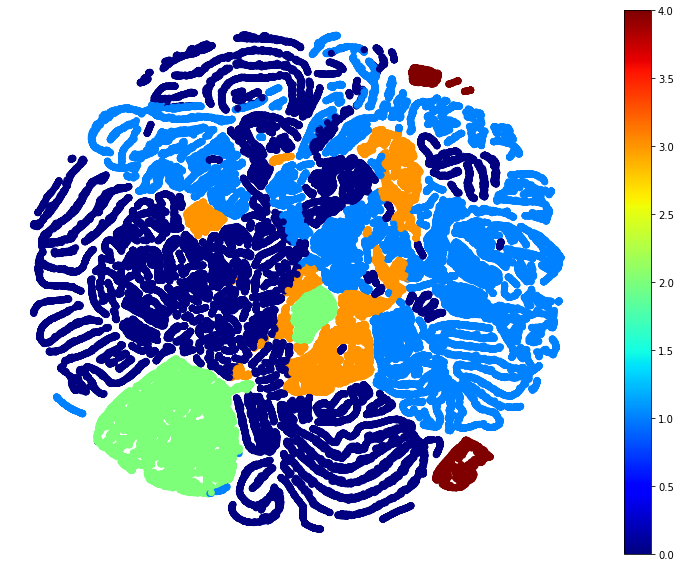

In [ ]:
#Plotting of K-Means Cluster
plt.figure(figsize=(13,10 ))
plt.scatter(df_reduced[:, 0], df_reduced[:, 1],c=y_pred, cmap="jet")
plt.axis('off')
plt.colorbar()
plt.show()

#### So we can see from the T-SNE plot for the K-Mean Model that the clusters are optimal

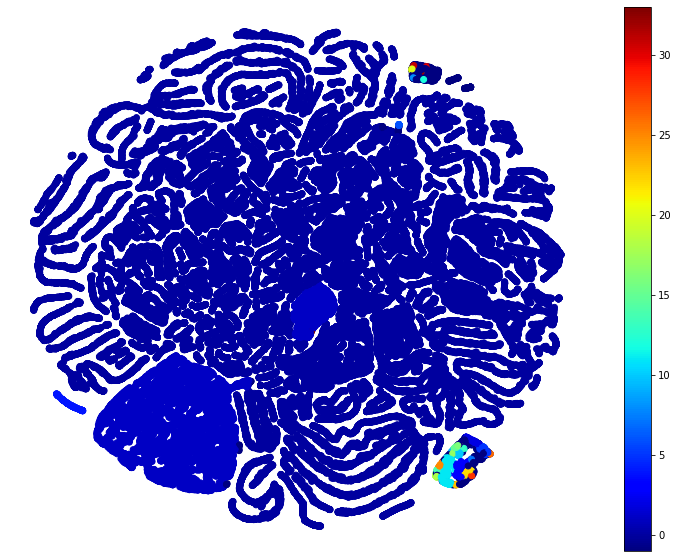

In [ ]:
#Plotting of DBSCAN Cluster
plt.figure(figsize=(13,10 ))
plt.scatter(df_reduced[:, 0], df_reduced[:, 1],c=predicted_labels, cmap="jet")
plt.axis('off')
plt.colorbar()
plt.show()

#### DBSCAN model might require more hyperparameter tuning to get the optimal model (needs atleast 30-35gb memory with the given size of the data)

# 6 Analyse customer clusters and find different behaviors

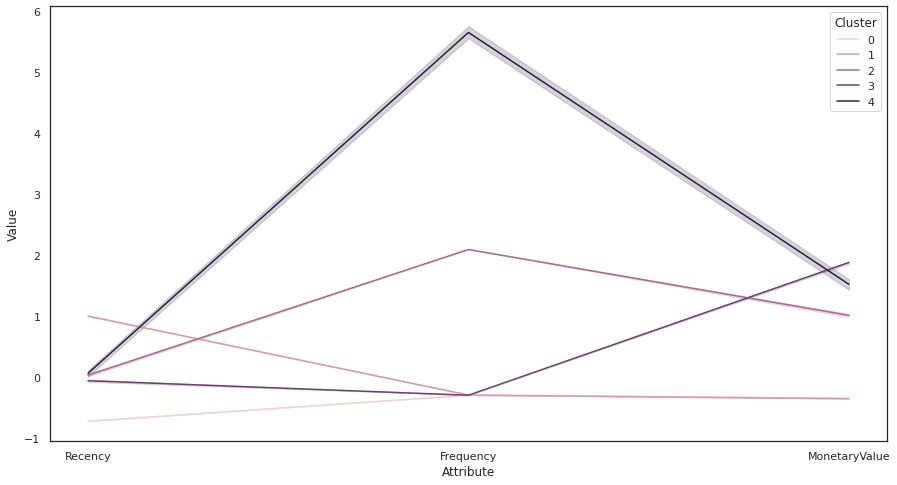

In [ ]:
#To Create a Snake plot to get more insights into the clusters formed by the K-Means model
df_normalized = pd.DataFrame(RFM_normalized, columns=['Recency', 'Frequency', 'MonetaryValue'])
df_normalized['ID'] = RFM.index
df_normalized['Cluster'] = model.labels_
# Melt The Data
df_nor_melt = pd.melt(df_normalized.reset_index(),
                      id_vars=['ID', 'Cluster'],
                      value_vars=['Recency','Frequency','MonetaryValue'],
                      var_name='Attribute',
                      value_name='Value')
df_nor_melt.head()
# Visualize it
plt.figure(figsize=(15,8))
sns.lineplot('Attribute', 'Value', hue='Cluster', data=df_nor_melt)

### From the above Snake plot we can make some analysis about the clusters:
### Cluster 4 has Low Recency, High Frequence and High Monetary value so they are 'Champions'
### Cluster 3 has Low Recency, Low Frequency and High Monetary value so they are 'Premium Customers' 
### Cluster 2 has Low Recency, High Frequency and Moderate Monetary value, they are 'Potential Loyalists'
### Cluster 1 has High Recency, Low Frequency and Low Monetary value, they are 'Churned customers'
### Cluster 0 has Low Recency, Low Frequency and Low Monetary value, they are 'New Customers'